In [1]:
%config IPCompleter.use_jedi = False
import pandas as pd
import warnings 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

from pathlib import Path

In [2]:
proj_path = Path().resolve().parent
print(proj_path)

/home/mommess/Documents/Leeds_research/JPDC_paper/data


In [3]:
FONT_NAME = 'Arial'
FONT_SIZE = 21
import matplotlib as mpl
mpl.rc('font',family='Arial')

In [4]:
file_2d = proj_path / "results/density2D_64_128.csv" 
file_ts = proj_path / "results/densityTS_64_128.csv"
file_large = proj_path / "results/large2D_64_128.csv"
file_largeTS = proj_path / "results/largeTS_64_128.csv"

In [5]:
df_2d_column_names = ['FF', 
        'FFD-Avg', 'FFD-Max', 'FFD-AvgExpo', 'FFD-Surrogate', 'FFD-ExtendedSum',
        'BFD-Avg', 'BFD-Max', 'BFD-AvgExpo', 'BFD-Surrogate', 'BFD-ExtendedSum',
        'WFD-Avg', 'WFD-Max', 'WFD-AvgExpo', 'WFD-Surrogate', 'WFD-ExtendedSum',
        'NCD-L2Norm', 'NCD-DotProduct', 'NCD-DotDivision',
        'RefineWFD-Avg-5', 'RefineWFD-Avg-3', 'RefineWFD-Avg-2',
        'SpreadWFD-Avg', 'SpreadWFD-Max', 'SpreadWFD-Surrogate',
        'NCD-Fitness', 'FFD-Degree', 'NodeCount',
       ]

df_2d_multinode = [
    'RefineWFD-Avg-5', 'RefineWFD-Avg-3', 'RefineWFD-Avg-2',
    'SpreadWFD-Avg', 'SpreadWFD-Max', 'SpreadWFD-Surrogate']

df_2d_column_names_small = ['FF', 'BFD-Avg', 'WFD-AvgExpo', 'NCD-DotProduct', 
                            'RefineWFD-Avg-2', #'RefineWFD-Avg-5', 'RefineWFD-Avg-3', 'RefineWFD-Avg-2',
                            'SpreadWFD-Avg',
                            'NCD-Fitness', 'FFD-Degree', 'NodeCount'
                           ]
df_2d_large_column_names = ['FF', 'BFD-Avg', 'WFD-AvgExpo', 'NCD-DotProduct', 
                            'RefineWFD-Avg-2',
                            'SpreadWFD-Avg',
                            'NCD-Fitness', 'FFD-Degree'
                           ]

df_ts_column_names = ['FF', 'BFD-Avg', 'WFD-AvgExpo', 'RefineWFD-Avg-2', 'SpreadWFD-Avg', 'FFD-Degree']

df_ts_large_column_names = ['FF', 'BFD-Avg', 'WFD-AvgExpo', 'RefineWFD-Avg-2', 'SpreadWFD-Avg', 'FFD-Degree']

classes = ['arbitrary', 'normal', 'threshold']

rename_dict = {
    "FFD-Degree": "Medea-TP",
    "NodeCount": "Medea-NC",
    "NCD-Fitness": "LRASched-Fitness",
    "NCD-DotDivision": "NCD-TightFill",
    "FFD-AvgExpo": "FFD-AvgExp",
    "BFD-AvgExpo": "BFD-AvgExp",
    "WFD-AvgExpo": "WFD-AvgExp",
    "SpreadWFD-Avg": "SpreadWFD-Avg-BinSearch",
    "RefineWFD-Avg-2": "SpreadWFD-Avg-Decr2",
}

In [6]:
## sub_df = any one in df_2d, df_ts, df_large
def get_exp_results(sub_df, alg_column_names):
    sub_df['class'] = sub_df['instance_name'].apply(lambda x: x.split('_')[0])
    sub_df['idx'] = sub_df['instance_name'].apply(lambda x: int(x.split('_')[2]))
    sub_df['density'] = sub_df['instance_name'].apply(lambda x: int(x.split('_')[1][1:]))
    
    for i in alg_column_names:
        sub_df[i + '_eps'] = (round(sub_df[i]/sub_df['LB'] - 1, 3))*100 # *100 to get percentage value
        sub_df[i + '_time'] = sub_df[i + '_time'].apply(lambda x: round(x, 4))

    epsilon_column_names = [i + '_eps' for i in alg_column_names]
    time_column_names = [i + '_time' for i in alg_column_names]
    sub_df_grouped_avg = sub_df.groupby(by = ['class', 'density'], as_index=False).mean()
    eps_df = sub_df_grouped_avg[['class', 'density'] + epsilon_column_names]
    time_df = sub_df_grouped_avg[['class', 'density'] + time_column_names]
    return eps_df, time_df

In [7]:
## sub_df = any one in df_2d, df_ts, df_large
def get_scale_exp_results(sub_df, alg_column_names):
    sub_df['class'] = sub_df['instance_name'].apply(lambda x: x.split('_')[3])
    sub_df['LRAnum'] = sub_df['instance_name'].apply(lambda x: int(x.split('_')[2]))
    sub_df['idx'] = sub_df['instance_name'].apply(lambda x: int(x.split('_')[-1]))
    
    for i in alg_column_names:
        sub_df[i + '_eps'] = (round(sub_df[i]/sub_df['LB'] - 1, 3))*100 # *100 to get percentage value
        sub_df[i + '_time'] = sub_df[i + '_time'].apply(lambda x: round(x, 4))

    epsilon_column_names = [i + '_eps' for i in alg_column_names]
    time_column_names = [i + '_time' for i in alg_column_names]
    sub_df_grouped_avg = sub_df.groupby(by = ['class', 'LRAnum'], as_index=False).mean()
    sub_df_grouped_avg_eps = sub_df_grouped_avg[['class', 'LRAnum'] + epsilon_column_names]
    sub_df_grouped_avg_time = sub_df_grouped_avg[['class', 'LRAnum'] + time_column_names]
    return sub_df_grouped_avg_eps, sub_df_grouped_avg_time

In [36]:
def plot_barchart(original_df, class_name, cols, xlabel, ylabel, legend_args={'width':16, 'height':6.5, 'loc':'upper center', 'anchor_x':0.5, 'anchor_y':-0.25, 'ncol':5, 'fontsize':FONT_SIZE, 'enabled':True}, log_scale=False):
    tmp_df = original_df[original_df['class'] == class_name][cols]
    tmp_df.rename(columns=rename_dict, errors='ignore', inplace=True)
    # group of densities/scale
    width = 0.09
    labels = original_df.density.apply(lambda x: f'{x:,}').unique()
    x = np.arange(len(labels))

    fig = plt.figure(figsize=(legend_args['width'], legend_args['height']))
    algs = list(tmp_df.T.index)
    alg_num = len(tmp_df.T)
    alg_res = tmp_df.T.values

    width_class = width * alg_num + 0.15
    #width = 0.95/float(alg_num) # 0.06
    
    curr = alg_num/2.0 + 0.5 #int(alg_num/2)+1
    hatches = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*',
               '/o', '\\|', '|*', '-\\', '+o', 'x*', 'o-', 'O|', 'O.', '*-',
               '//', '\\\\', '||', '--', '++', 'xx', 'oo', 'OO', '..', '**']

    for i in range(alg_num):
        curr = curr - 1
        plt.bar(x*width_class - width*curr, alg_res[i], width, hatch = hatches[i], alpha=.99)
    
    plt.xticks(x*width_class, labels, fontsize=FONT_SIZE+5, fontweight='bold')
    plt.yticks(fontsize=FONT_SIZE+5, fontweight='bold')
    # plt.axhline(1.17*max([max(alg_res[i]) for i in range(alg_num)]), linewidth=0)
    #plt.title((class_name.capitalize() + " graphs"), fontsize=FONT_SIZE, fontname=FONT_NAME)
    plt.xlabel(xlabel, fontname=FONT_NAME, fontsize=FONT_SIZE+8, fontweight='bold')
    plt.ylabel(ylabel, fontname=FONT_NAME, fontsize=FONT_SIZE+8, fontweight='bold')
    if log_scale:
        plt.yscale('log')
    if legend_args['enabled']:
        plt.legend(algs, loc=legend_args['loc'], bbox_to_anchor=(legend_args['anchor_x'], legend_args['anchor_y']), ncol=legend_args['ncol'], fontsize=legend_args['fontsize'])
    plt.tight_layout()
    plt.show()
    fig.tight_layout()
    return fig


# Result-1: 2D Fixed Res Request

## 1.1 Impact of Affinity Density On Effectiveness and Time Consumption

In [9]:
df_2d = pd.read_csv(file_2d, sep='\t')

In [10]:
twodim_eps, twodim_time = get_exp_results(df_2d, df_2d_column_names)
twodim_eps.columns = ['class', 'density'] + df_2d_column_names
twodim_time.columns = ['class', 'density'] + df_2d_column_names

#### The algorithm effectivenss and time consumption of the three different classes 

In [11]:
twodim_eps

,class,density,FF,FFD-Avg,FFD-Max,FFD-AvgExpo,FFD-Surrogate,FFD-ExtendedSum,BFD-Avg,BFD-Max,...,NCD-DotDivision,RefineWFD-Avg-5,RefineWFD-Avg-3,RefineWFD-Avg-2,SpreadWFD-Avg,SpreadWFD-Max,SpreadWFD-Surrogate,NCD-Fitness,FFD-Degree,NodeCount
0,arbitrary,1,12.22,12.22,12.22,12.22,12.22,15.55,12.22,12.22,...,11.64,7.22,5.92,5.21,4.47,4.47,4.47,11.64,12.20,12.24
1,arbitrary,5,12.16,12.16,12.16,12.16,12.16,15.52,12.16,12.16,...,11.47,7.16,6.46,5.34,4.39,4.39,4.39,11.47,12.29,12.61
2,arbitrary,10,12.06,12.06,12.06,12.06,12.06,15.61,12.06,12.06,...,11.38,7.03,6.03,5.63,4.64,4.64,4.64,11.38,12.09,12.93
3,normal,1,12.21,12.21,12.21,12.21,12.21,15.57,12.21,12.21,...,11.57,7.21,6.21,4.80,4.21,4.21,4.21,11.57,12.21,12.20
4,normal,5,12.14,12.14,12.14,12.14,12.14,15.58,12.14,12.14,...,11.66,7.13,6.13,5.72,4.54,4.54,4.54,11.66,12.11,12.34
5,normal,10,12.03,12.03,12.03,12.03,12.03,15.62,12.03,12.03,...,11.43,7.02,6.32,5.21,4.32,4.32,4.32,11.43,12.00,12.21
6,threshold,1,12.18,12.18,12.18,12.18,12.18,15.57,12.18,12.18,...,11.58,7.18,6.18,4.37,3.64,3.64,3.64,11.58,12.33,12.35
7,threshold,5,12.09,12.09,12.09,12.09,12.09,15.77,12.09,12.09,...,11.51,8.58,7.28,6.88,6.10,6.10,6.10,11.51,12.17,12.25
8,threshold,10,11.93,11.93,11.93,11.93,11.93,16.05,11.93,11.93,...,11.37,11.93,10.72,10.52,9.68,9.68,9.68,11.37,12.12,12.12


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
/run/user/1000/ipykernel_4022/1684783776.py:36: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


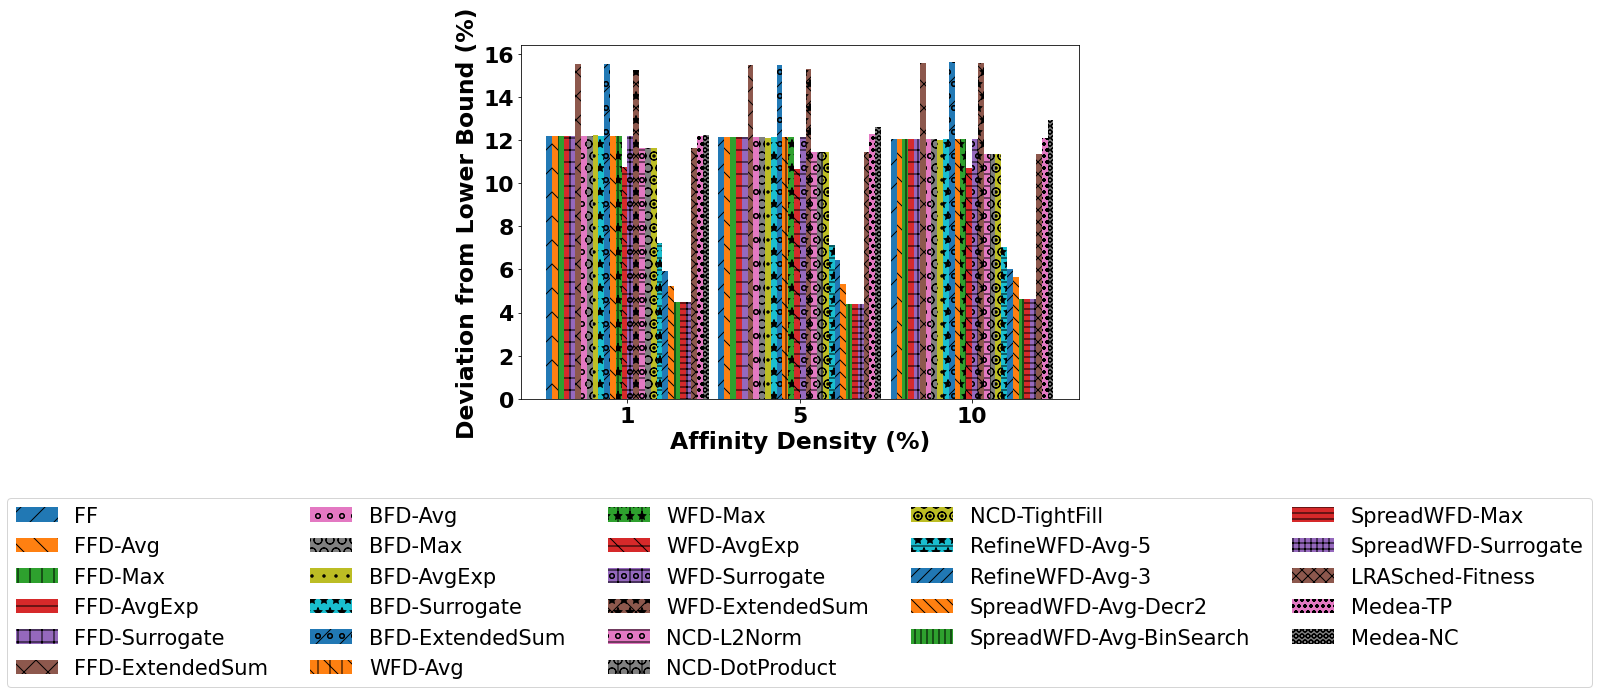

/run/user/1000/ipykernel_4022/1684783776.py:38: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


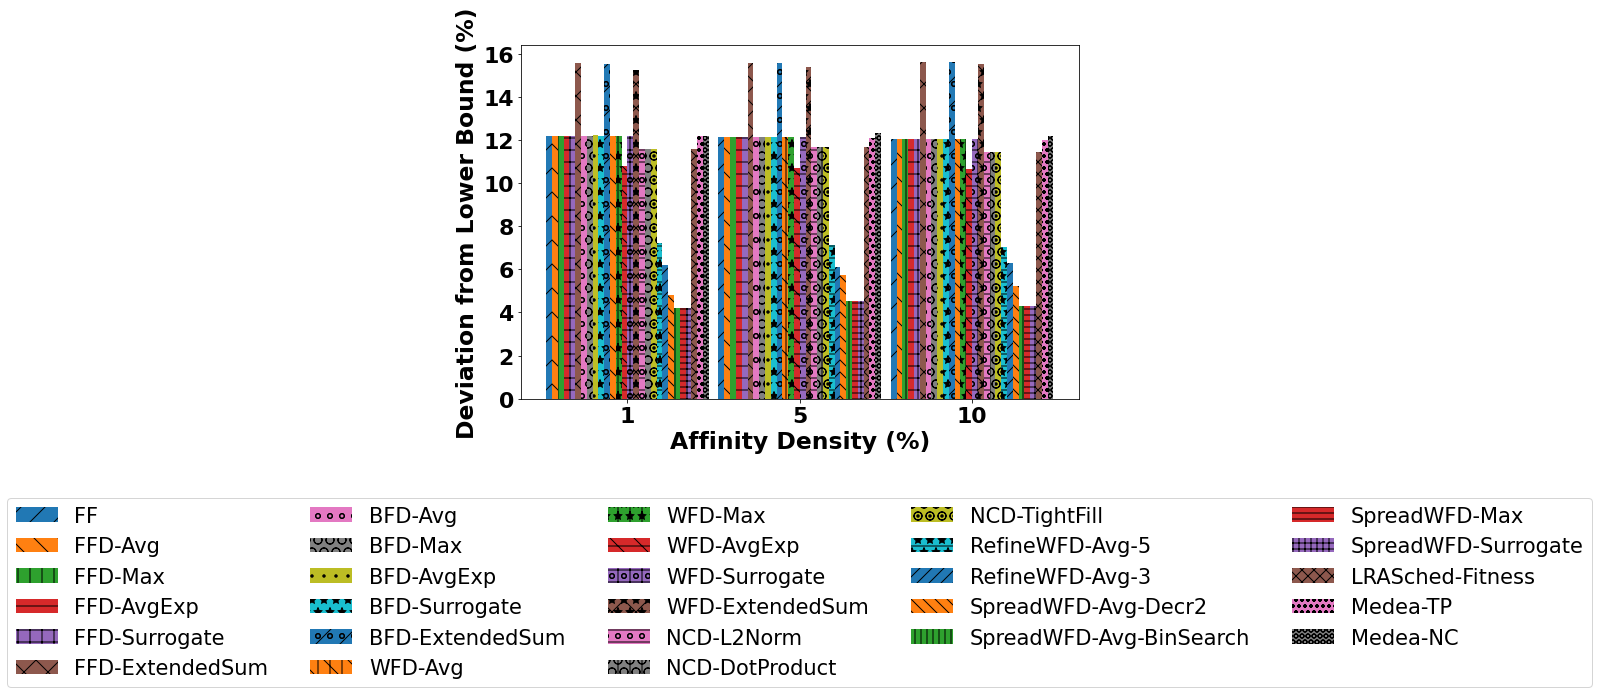

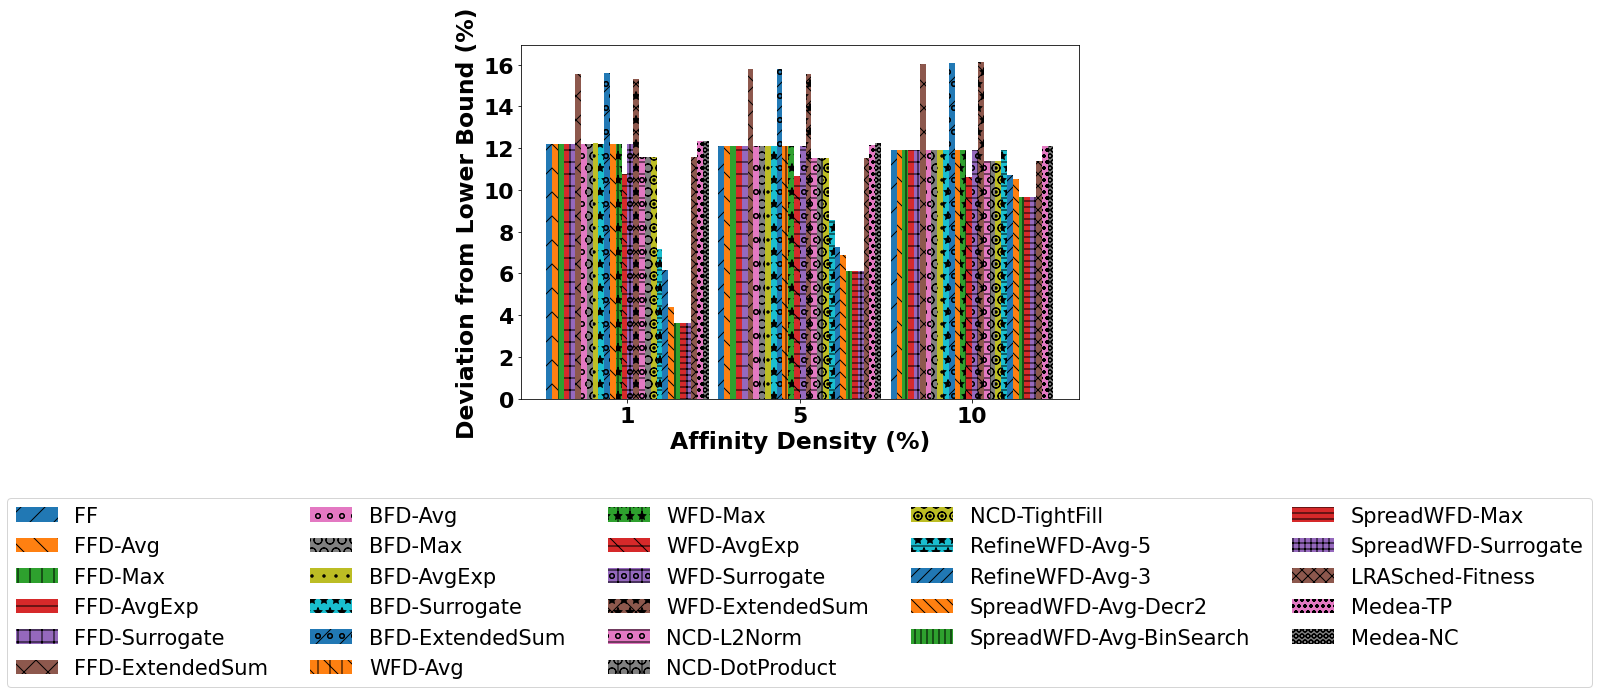

In [12]:
for c in classes:
    legend_args={'width':10, 'height':6.5,'loc':'upper center', 'anchor_x':0.5, 'anchor_y':-0.25, 'ncol':5, 'fontsize':FONT_SIZE, 'enabled':True}
    fig = plot_barchart(twodim_eps, c, df_2d_column_names, "Affinity Density (%)", 'Deviation from Lower Bound (%)', legend_args)
    #filename = f"{proj_path}/plots/density2D_result_{c}.pdf" 
    #fig.savefig(filename)

/run/user/1000/ipykernel_4022/1684783776.py:36: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


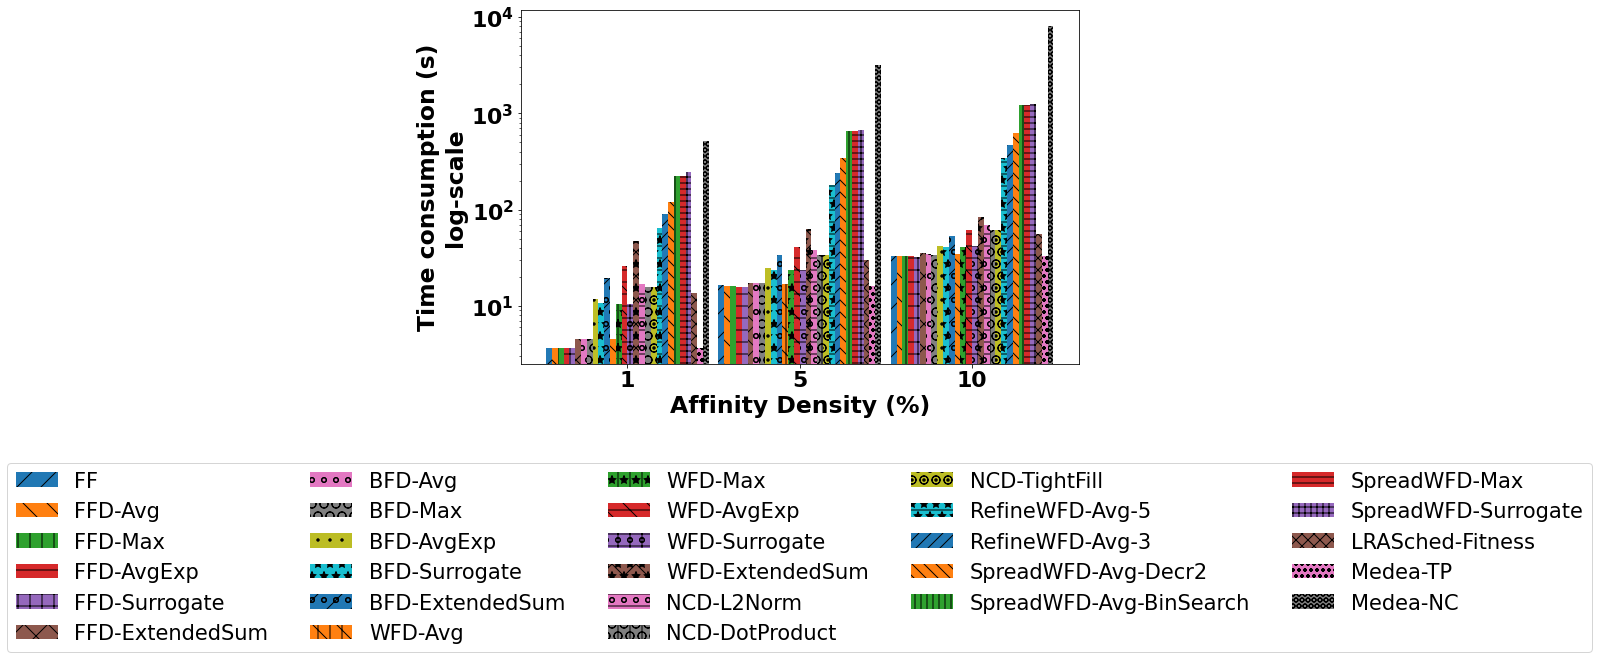

/run/user/1000/ipykernel_4022/1684783776.py:38: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


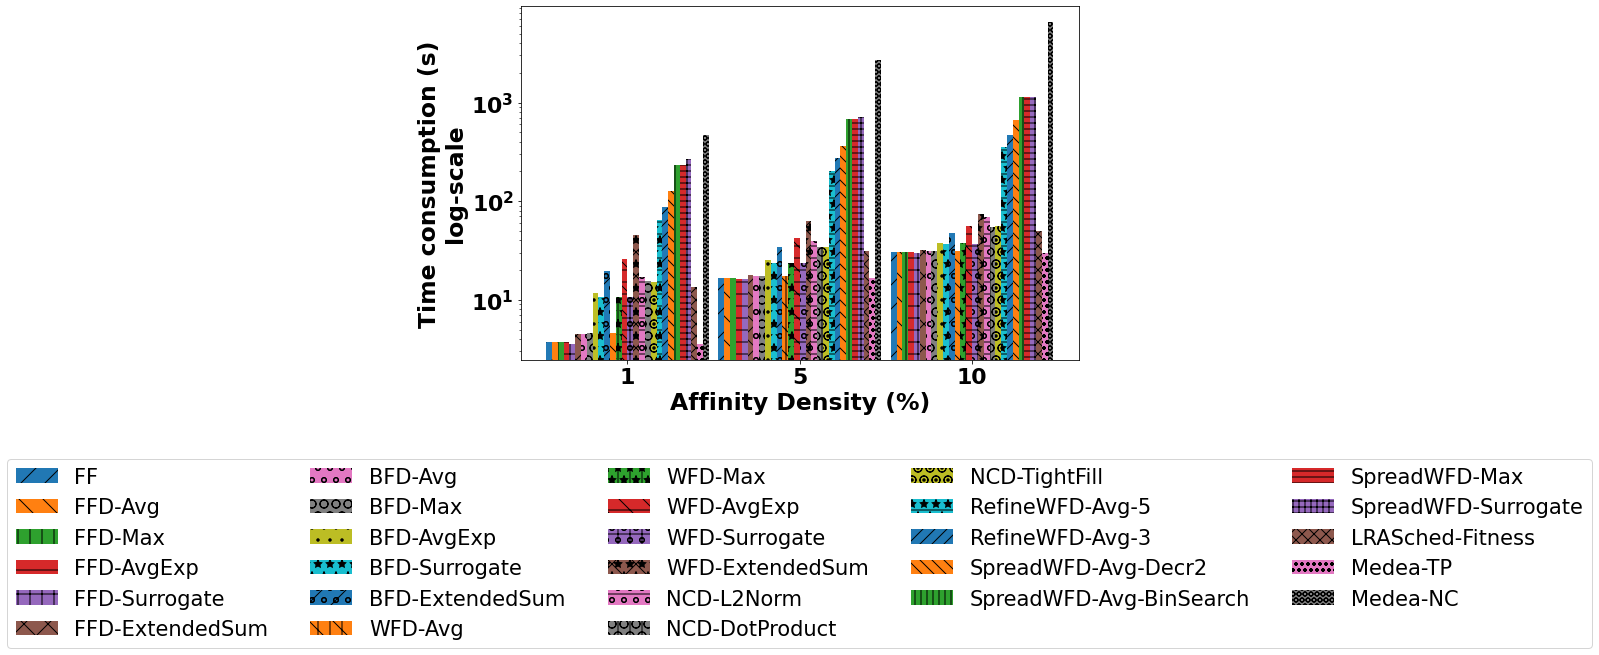

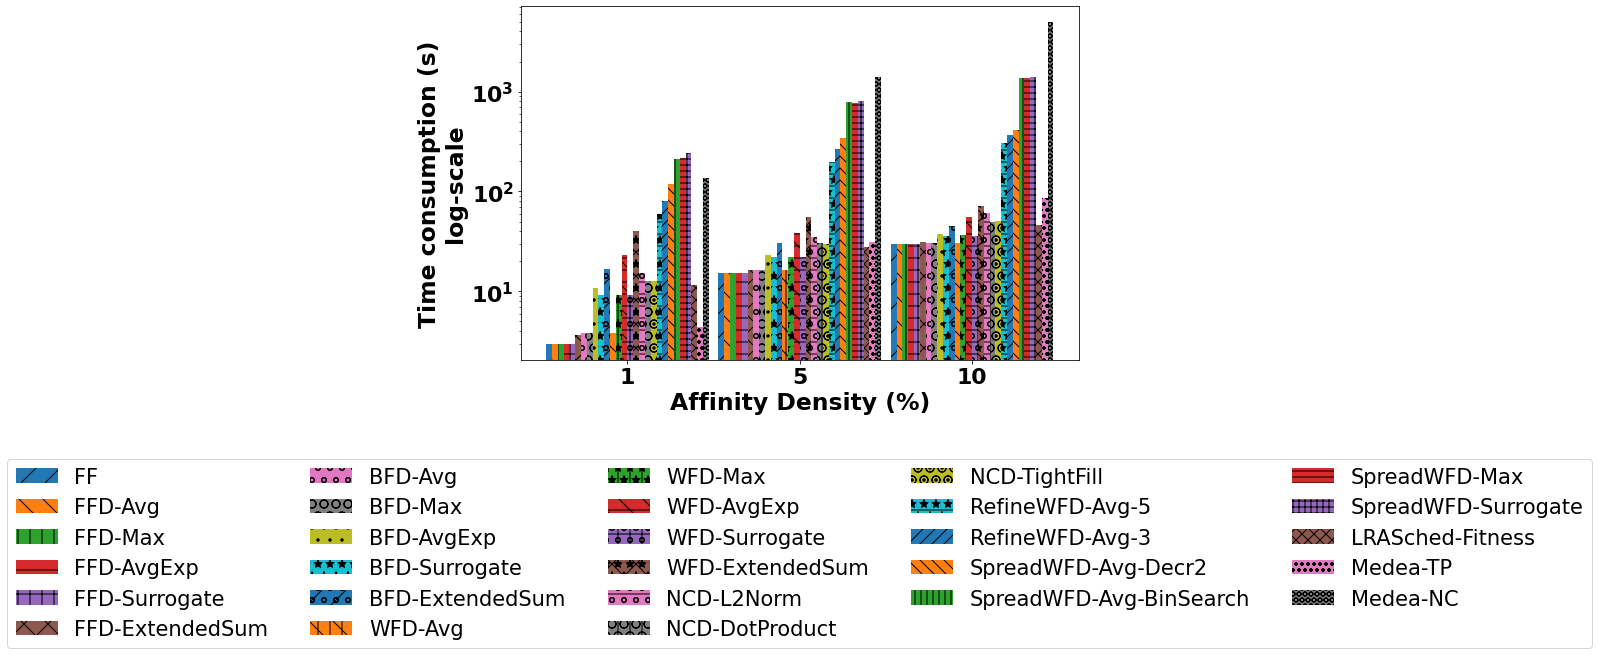

In [13]:
for c in classes: 
    legend_args={'width':10, 'height':6.5,'loc':'upper center', 'anchor_x':0.5, 'anchor_y':-0.25, 'ncol':5, 'fontsize':FONT_SIZE, 'enabled':True}
    fig = plot_barchart(twodim_time, c, df_2d_column_names,
                        "Affinity Density (%)",
                        'Time consumption (s)\nlog-scale', legend_args, True)
    #filename = f"{proj_path}/plots/density2D_time_{c}.pdf" 
    #fig.savefig(filename)

In [14]:
twodim_time

,class,density,FF,FFD-Avg,FFD-Max,FFD-AvgExpo,FFD-Surrogate,FFD-ExtendedSum,BFD-Avg,BFD-Max,...,NCD-DotDivision,RefineWFD-Avg-5,RefineWFD-Avg-3,RefineWFD-Avg-2,SpreadWFD-Avg,SpreadWFD-Max,SpreadWFD-Surrogate,NCD-Fitness,FFD-Degree,NodeCount
0,arbitrary,1,3.7,3.7,3.7,3.7,3.7,4.5,4.5,4.5,...,15.6,64.1,89.7,121.2,225.4,226.0,248.9,13.7,3.7,512.1
1,arbitrary,5,16.4,16.2,16.2,15.9,15.8,17.4,17.3,17.4,...,33.8,181.0,240.0,340.3,652.8,657.0,673.8,30.3,16.2,3200.1
2,arbitrary,10,32.8,33.2,32.9,32.8,32.4,35.4,34.4,34.1,...,62.1,344.6,472.9,622.2,1214.6,1216.7,1245.5,55.6,32.8,8004.9
3,normal,1,3.7,3.7,3.7,3.7,3.6,4.5,4.5,4.6,...,15.3,64.9,87.4,126.1,233.6,232.9,264.9,13.4,3.6,465.5
4,normal,5,16.6,16.7,16.7,16.3,16.3,17.9,17.6,17.5,...,34.3,200.2,272.2,361.8,684.2,686.5,715.3,30.9,16.5,2674.6
5,normal,10,30.4,30.8,30.5,30.5,29.8,32.3,31.3,30.9,...,56.2,351.6,468.5,657.5,1146.4,1137.4,1149.4,49.7,30.0,6490.9
6,threshold,1,3.0,3.0,3.0,3.0,3.0,3.7,3.8,3.8,...,12.7,59.0,79.9,118.4,213.7,214.6,240.7,11.6,4.4,137.8
7,threshold,5,15.3,15.4,15.4,15.3,15.4,16.3,16.3,16.3,...,30.0,196.6,266.1,339.4,780.1,777.4,807.1,27.8,31.1,1394.0
8,threshold,10,29.8,29.7,29.7,29.6,29.7,31.3,30.7,30.8,...,50.1,302.3,364.9,412.9,1353.1,1359.4,1386.7,46.3,85.8,4929.5


### Same plots with subset of columns

In [15]:
twodim_eps_small = twodim_eps[['class', 'density'] +df_2d_column_names_small]
twodim_time_small = twodim_time[['class', 'density'] +df_2d_column_names_small]

In [16]:
twodim_eps_small

,class,density,FF,BFD-Avg,WFD-AvgExpo,NCD-DotProduct,RefineWFD-Avg-2,SpreadWFD-Avg,NCD-Fitness,FFD-Degree,NodeCount
0,arbitrary,1,12.22,12.22,10.75,11.64,5.21,4.47,11.64,12.20,12.24
1,arbitrary,5,12.16,12.16,10.68,11.47,5.34,4.39,11.47,12.29,12.61
2,arbitrary,10,12.06,12.06,10.71,11.38,5.63,4.64,11.38,12.09,12.93
3,normal,1,12.21,12.21,10.78,11.57,4.80,4.21,11.57,12.21,12.20
4,normal,5,12.14,12.14,10.70,11.66,5.72,4.54,11.66,12.11,12.34
5,normal,10,12.03,12.03,10.67,11.43,5.21,4.32,11.43,12.00,12.21
6,threshold,1,12.18,12.18,10.74,11.58,4.37,3.64,11.58,12.33,12.35
7,threshold,5,12.09,12.09,10.65,11.51,6.88,6.10,11.51,12.17,12.25
8,threshold,10,11.93,11.93,10.60,11.37,10.52,9.68,11.37,12.12,12.12


In [18]:
twodim_eps_small[twodim_eps_small['class'] == 'arbitrary'][df_2d_column_names_small].mean()

FF                 12.146667
BFD-Avg            12.146667
WFD-AvgExpo        10.713333
NCD-DotProduct     11.496667
RefineWFD-Avg-2     5.393333
SpreadWFD-Avg       4.500000
NCD-Fitness        11.496667
FFD-Degree         12.193333
NodeCount          12.593333
dtype: float64

In [19]:
twodim_eps_small[df_2d_column_names_small].mean()

FF                 12.113333
BFD-Avg            12.113333
WFD-AvgExpo        10.697778
NCD-DotProduct     11.512222
RefineWFD-Avg-2     5.964444
SpreadWFD-Avg       5.110000
NCD-Fitness        11.512222
FFD-Degree         12.168889
NodeCount          12.361111
dtype: float64

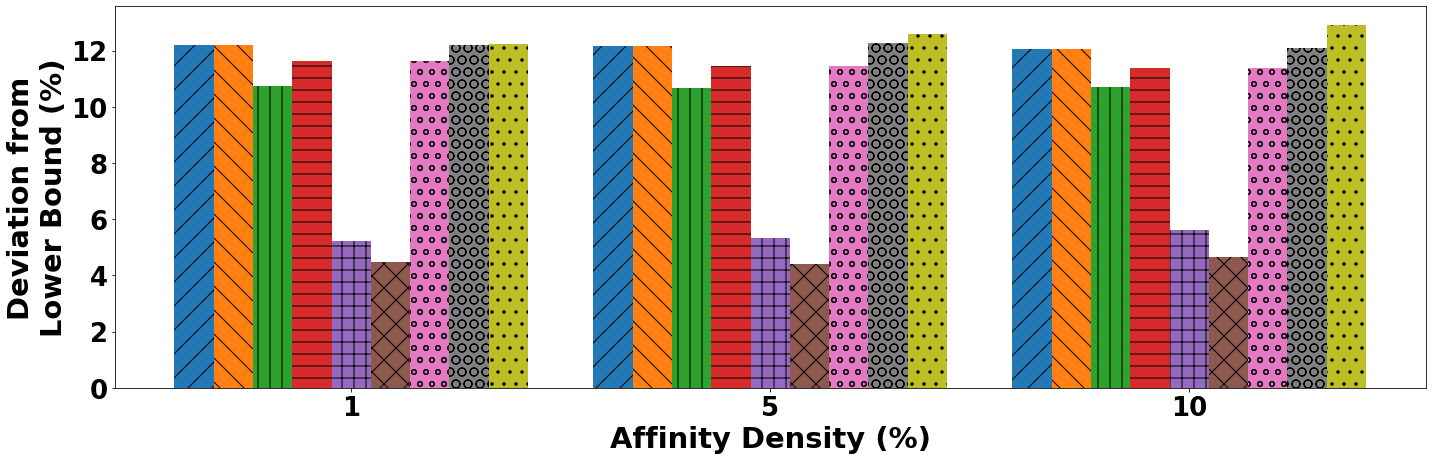

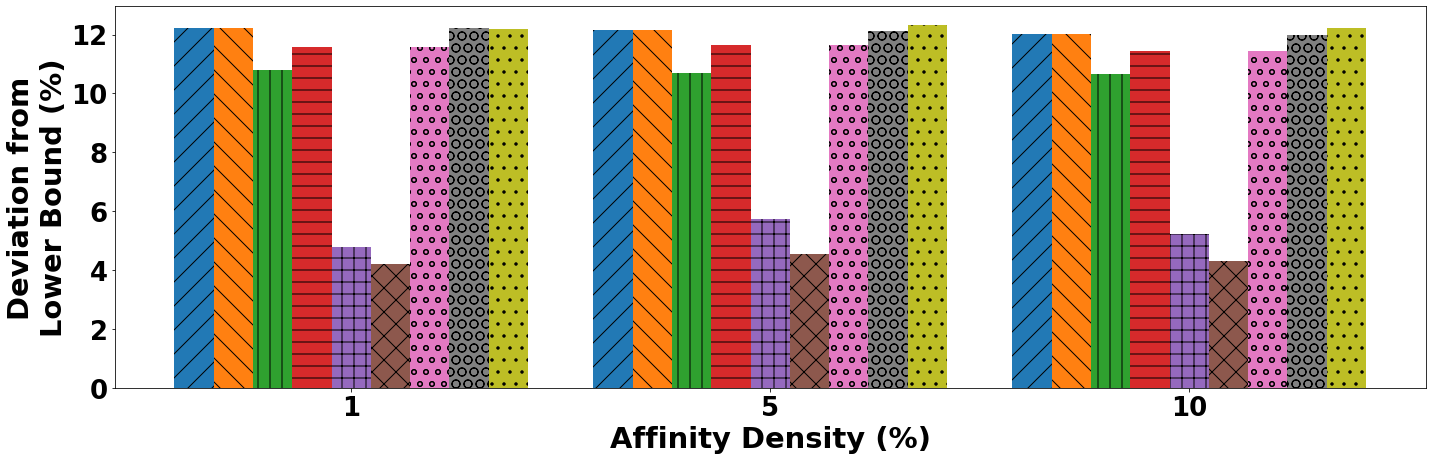

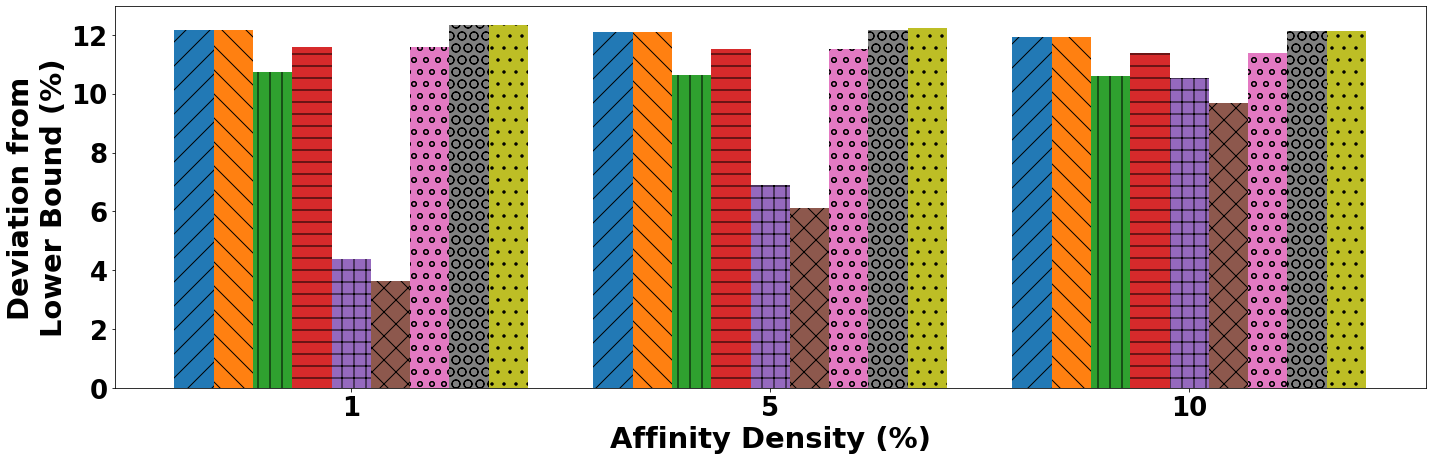

In [38]:
for c in classes: 
#c = "arbitrary"
    #legend_args={'width':14, 'height':6.5,'loc':'center', 'anchor_x':1.15, 'anchor_y':0.4, 'ncol':1, 'fontsize':FONT_SIZE-4, 'enabled':True}
    legend_args={'width':20, 'height':6.5,'loc':'lower left', 'anchor_x':0.01, 'anchor_y':0.01, 'ncol':4, 'fontsize':FONT_SIZE, 'enabled':False}
    fig = plot_barchart(twodim_eps, c, df_2d_column_names_small, "Affinity Density (%)", 'Deviation from\nLower Bound (%)',legend_args)
    filename = f"{proj_path}/plots/density2D_small2_result_{c}.pdf" 
    fig.savefig(filename)

In [17]:
twodim_time_small

,class,density,FF,BFD-Avg,WFD-AvgExpo,NCD-DotProduct,RefineWFD-Avg-2,SpreadWFD-Avg,NCD-Fitness,FFD-Degree,NodeCount
0,arbitrary,1,3.7,4.5,26.3,15.8,121.2,225.4,13.7,3.7,512.1
1,arbitrary,5,16.4,17.3,41.4,34.1,340.3,652.8,30.3,16.2,3200.1
2,arbitrary,10,32.8,34.4,61.1,62.2,622.2,1214.6,55.6,32.8,8004.9
3,normal,1,3.7,4.5,26.0,15.4,126.1,233.6,13.4,3.6,465.5
4,normal,5,16.6,17.6,42.0,34.5,361.8,684.2,30.9,16.5,2674.6
5,normal,10,30.4,31.3,55.4,54.3,657.5,1146.4,49.7,30.0,6490.9
6,threshold,1,3.0,3.8,23.3,12.7,118.4,213.7,11.6,4.4,137.8
7,threshold,5,15.3,16.3,38.5,30.3,339.4,780.1,27.8,31.1,1394.0
8,threshold,10,29.8,30.7,55.1,49.4,412.9,1353.1,46.3,85.8,4929.5


In [44]:
twodim_time_small[twodim_time_small['class'] == 'arbitrary']

,class,density,FF,BFD-Avg,WFD-AvgExpo,NCD-DotProduct,RefineWFD-Avg-2,SpreadWFD-Avg,NCD-Fitness,FFD-Degree,NodeCount
0,arbitrary,1,3.7,4.5,26.3,15.8,121.2,225.4,13.7,3.7,512.1
1,arbitrary,5,16.4,17.3,41.4,34.1,340.3,652.8,30.3,16.2,3200.1
2,arbitrary,10,32.8,34.4,61.1,62.2,622.2,1214.6,55.6,32.8,8004.9


In [18]:
twodim_time_small.groupby("density").mean()

,FF,BFD-Avg,WFD-AvgExpo,NCD-DotProduct,RefineWFD-Avg-2,SpreadWFD-Avg,NCD-Fitness,FFD-Degree,NodeCount
density,,,,,,,,,
1,3.466667,4.266667,25.200000,14.633333,121.900000,224.233333,12.900000,3.900000,371.8
5,16.100000,17.066667,40.633333,32.966667,347.166667,705.700000,29.666667,21.266667,2422.9
10,31.000000,32.133333,57.200000,55.300000,564.200000,1238.033333,50.533333,49.533333,6475.1


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


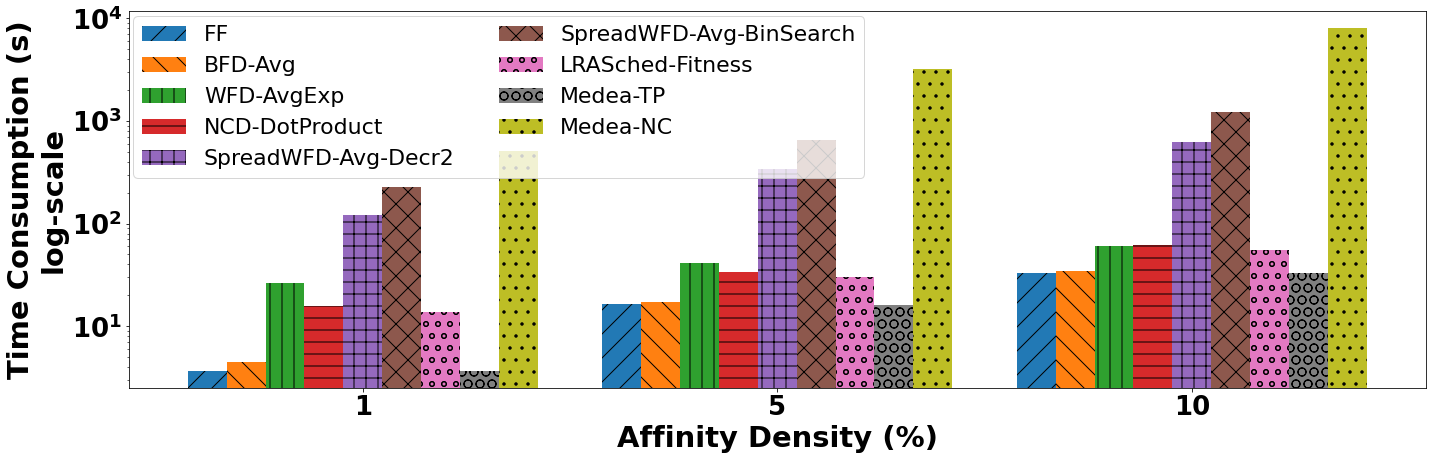

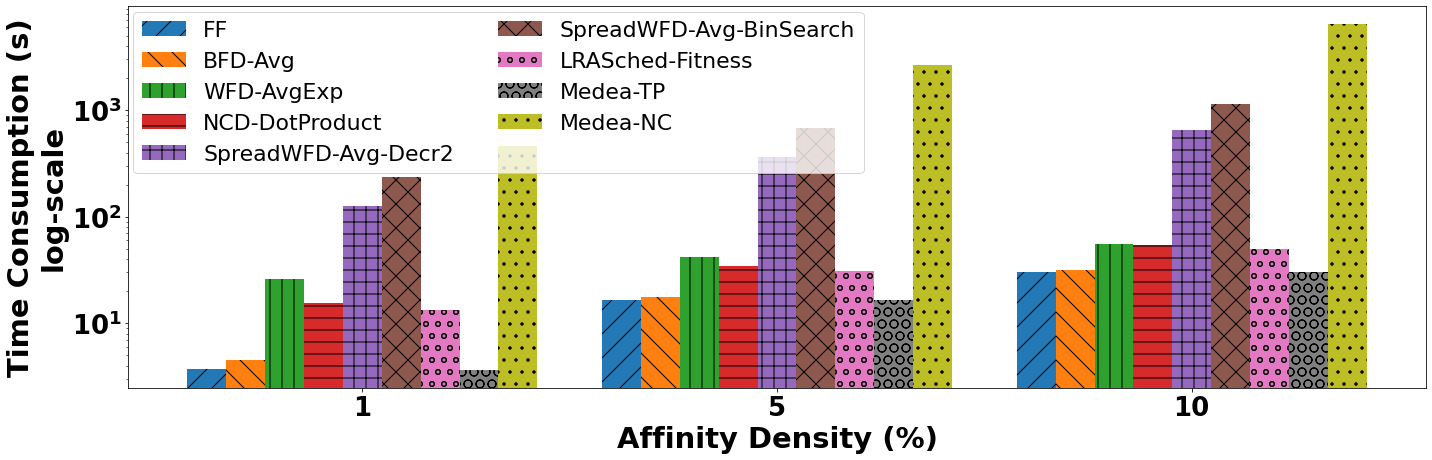

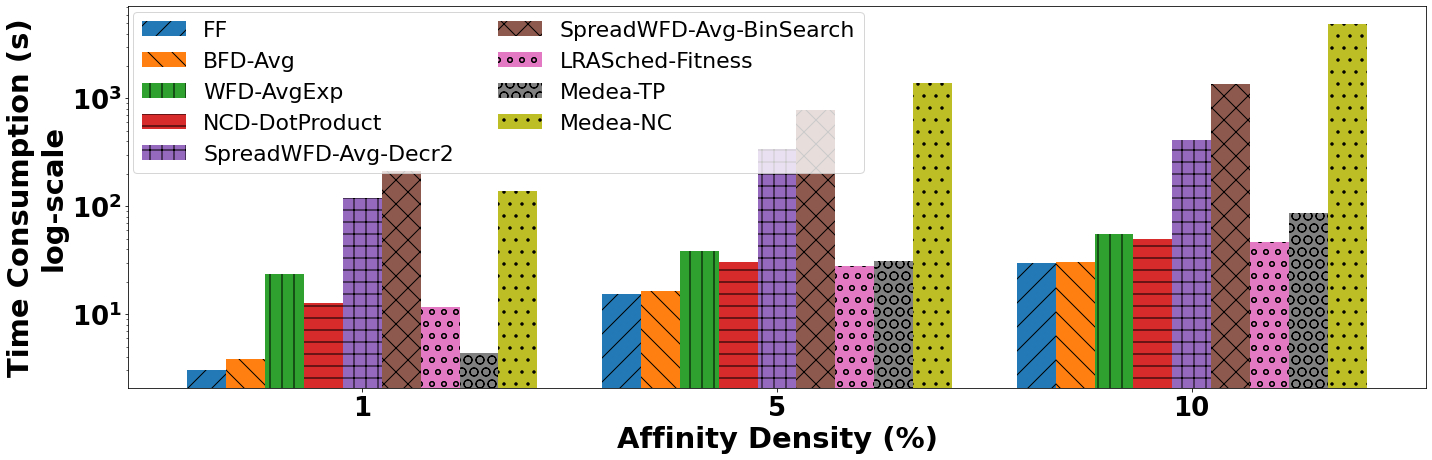

In [39]:
for c in classes: 
    #legend_args={'width':14, 'height':6.5,'loc':'center', 'anchor_x':1.15, 'anchor_y':0.4, 'ncol':1, 'fontsize':FONT_SIZE-4, 'enabled':True}
    legend_args={'width':20, 'height':6.5,'loc':'upper left', 'anchor_x':-0.005, 'anchor_y':1.015, 'ncol':2, 'fontsize':FONT_SIZE+1, 'enabled':True}
#legend_args={'loc':'upper left', 'anchor_x':-0.005, 'anchor_y':1.015, 'ncol':2, 'fontsize':FONT_SIZE-0.5, 'enabled':True}
    fig = plot_barchart(twodim_time, c, df_2d_column_names_small, "Affinity Density (%)", 'Time Consumption (s)\nlog-scale', legend_args, True)
    filename = f"{proj_path}/plots/density2D_small2_time_{c}.pdf" 
    fig.tight_layout()
    fig.savefig(filename)


### Test summary plot

Time FF                          17.633333
BFD-Avg                     18.733333
WFD-AvgExp                  42.933333
NCD-DotProduct              37.366667
SpreadWFD-Avg-Decr2        361.233333
SpreadWFD-Avg-BinSearch    697.600000
LRASched-Fitness            33.200000
Medea-TP                    17.566667
dtype: float64
Efficiency FF                         12.146667
BFD-Avg                    12.146667
WFD-AvgExp                 10.713333
NCD-DotProduct             11.496667
SpreadWFD-Avg-Decr2         5.393333
SpreadWFD-Avg-BinSearch     4.500000
LRASched-Fitness           11.496667
Medea-TP                   12.193333
dtype: float64
['FF', 'BFD-Avg', 'WFD-AvgExp', 'NCD-DotProduct', 'SpreadWFD-Avg-Decr2', 'SpreadWFD-Avg-BinSearch', 'LRASched-Fitness', 'Medea-TP']


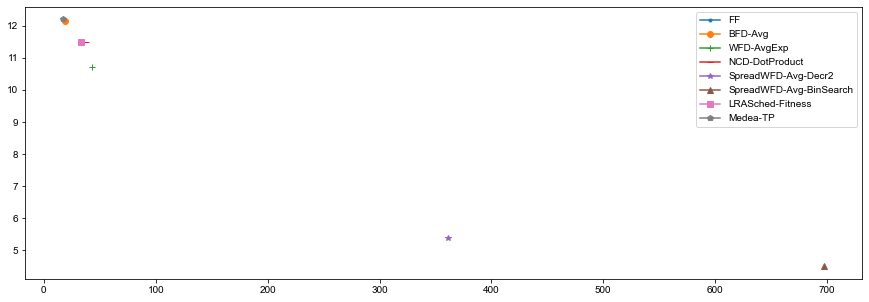

In [21]:
def plot_summary(df_result, df_time, class_name, cols, xlabel, ylabel, log_scale=False):
    df_result = df_result[df_result['class'] == class_name][cols]
    df_result.rename(columns=rename_dict, errors='ignore', inplace=True)
    df_time = df_time[df_time['class'] == class_name][cols]
    df_time.rename(columns=rename_dict, errors='ignore', inplace=True)
    
    df_result.drop('Medea-NC', axis=1, inplace=True)
    df_time.drop('Medea-NC', axis=1, inplace=True)
    
    x = df_time.mean()
    y = df_result.mean()
    
    print("Time", x)
    print("Efficiency", y)
    
    markers = ['.', 'o', '+', '_', '*', '^', 's', 'p', 'x', '|', 'd', '1', '2', '3', '4']
    
    fig = plt.figure(figsize=(15,5))
    algs = list(df_result.T.index)
    #algs.remove('Medea-NC')
    print(algs)
    alg_num = len(algs)
    
    
    
    
    for i in range(alg_num):
        plt.plot(x[i], y[i], marker=markers[i])
    #plt.plot(x, y, 'o')
    
    plt.legend(algs)
    if log_scale:
        plt.xscale('log')
    plt.show()
    return fig
    
fig = plot_summary(twodim_eps_small, twodim_time_small, 'arbitrary', df_2d_column_names_small, "time", "effectiveness", False)
filename = f"{proj_path}/plots/summary_arbitrary.pdf" 
fig.savefig(filename)

### Plot effectiveness and time in one figure

In [22]:
#for c in classes: 
#    #c = "arbitrary"
#    fig = plot_barchart(twodim_time, c, time_cols_without_nodecount, "Affinity Density (%)", 'Time Consumption (s)')

#    filename = f"{proj_path}/plots/density2D_time_{c}.pdf"
#    fig.savefig(filename)

In [23]:
def plot_one(original_df, class_name, cols, ax, labels, xlabel, ylabel, log_scale=False):
    tmp_df = original_df[original_df['class'] == class_name][cols]
    tmp_df.rename(columns=rename_dict, errors='ignore', inplace=True)
    # group of densities/scale
    width = 0.056
    # labels = original_df.density.apply(lambda x: f'{x:,}').unique()
    ind = np.arange(len(labels))

    alg_num = len(tmp_df.T)
    alg_res = tmp_df.T.values
    alg_names = tmp_df.columns.tolist()

    width_class = width * (alg_num + 2)
    #width = 0.95/float(alg_num) # 0.06

    hatches = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*',
                '/o', '\\|', '|*', '-\\', '+o', 'x*', 'o-', 'O|', 'O.', '*-']

    for i in range(alg_num):
        if alg_num == 15 and i == 14: # to mute Medea-NC
            ax.bar(ind*width_class, 0, 0)
        ax.bar(ind + i*width - width_class/2,
                alg_res[i], width, hatch=hatches[i], alpha=.99, label=alg_names[i])

    ax.set_xticks(ind)
    ax.set_xticklabels(labels, fontsize=FONT_SIZE*.9)
    ax.set_ylabel(ylabel, fontsize=FONT_SIZE*.9)
    if log_scale:
        ax.set_yscale('log')

In [24]:
def plot_barchart_density2D_result_time(data0, data1, filepath):
    labels = ['low density (1%)', 'medium density (5%)',
              'high density (10%)']

    fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=False, sharey=False)

    plot_one(*data0, axs[0], labels, "Affinity Density",
             'Deviation from Lower Bound (%)')
    plot_one(*data1, axs[1], labels, "Affinity Density",
             'Time Consumption (sec)')

    axs[0].set_yticks(np.arange(0, 20, step=4))
    axs[1].set_yticks(np.arange(0, 80, step=20))
    axs[0].set_yticklabels(np.arange(0, 20, step=4), fontsize=FONT_SIZE)
    axs[1].set_yticklabels(np.arange(0, 80, step=20), fontsize=FONT_SIZE)

    axs[0].set_title(
        '(a) Effectiveness of Different Affinity Densities', fontsize=FONT_SIZE*1.15, y=-.4)
    axs[1].set_title(
        '(b) Time Consumption of Different Affinity Densities', fontsize=FONT_SIZE*1.15, y=-.4)

    fig.legend(
        *(axs[0].get_legend_handles_labels()),
        bbox_to_anchor=(0.5, 1.09),
        loc='upper center',  ncol=4,
        fontsize=FONT_SIZE*0.75, frameon=True)

    plt.subplots_adjust(hspace=0.5)
    plt.savefig(filepath, bbox_inches='tight')


c = "arbitrary"
filename = f"{proj_path}/plots/density2D_result_time_{c}.pdf"
#plot_barchart_density2D_result_time(
#    (twodim_eps, c, df_2d_column_names),
#    (twodim_time, c, time_cols_without_nodecount),
#    filename)

## 1.2 Impact of LRA Submission Scale on Effectiveness and Time Consumption 

In [40]:
df_large = pd.read_csv(file_large, sep='\t') ## df_2d_large

In [41]:
twodim_eps_scale, twodim_time_scale = get_scale_exp_results(df_large, df_2d_large_column_names)
twodim_eps_scale.columns = ['class', 'density'] + df_2d_large_column_names
twodim_time_scale.columns = ['class', 'density'] + df_2d_large_column_names

In [42]:
twodim_eps_scale.sort_values(by='density')

,class,density,FF,BFD-Avg,WFD-AvgExpo,NCD-DotProduct,RefineWFD-Avg-2,SpreadWFD-Avg,NCD-Fitness,FFD-Degree
0,arbitrary,10000,2.70,2.70,2.28,2.60,2.50,1.88,2.60,2.74
3,normal,10000,2.70,2.70,2.27,2.61,2.50,1.61,2.61,2.75
6,threshold,10000,2.69,2.69,2.28,2.62,1.69,0.46,2.62,2.71
1,arbitrary,50000,2.43,2.43,1.95,2.34,1.63,0.56,2.34,2.41
4,normal,50000,2.44,2.44,1.94,2.35,2.04,0.57,2.35,2.42
7,threshold,50000,2.42,2.42,1.95,2.36,0.82,0.16,2.36,2.43
2,arbitrary,100000,2.40,2.40,1.93,2.32,1.20,0.31,2.32,2.40
5,normal,100000,2.39,2.39,1.91,2.32,0.99,0.25,2.32,2.40
8,threshold,100000,2.41,2.41,1.91,2.35,0.81,0.16,2.35,2.40


In [43]:
twodim_eps_scale[twodim_eps_scale['class'] == 'arbitrary'][df_2d_large_column_names].mean()

FF                 2.510000
BFD-Avg            2.510000
WFD-AvgExpo        2.053333
NCD-DotProduct     2.420000
RefineWFD-Avg-2    1.776667
SpreadWFD-Avg      0.916667
NCD-Fitness        2.420000
FFD-Degree         2.516667
dtype: float64

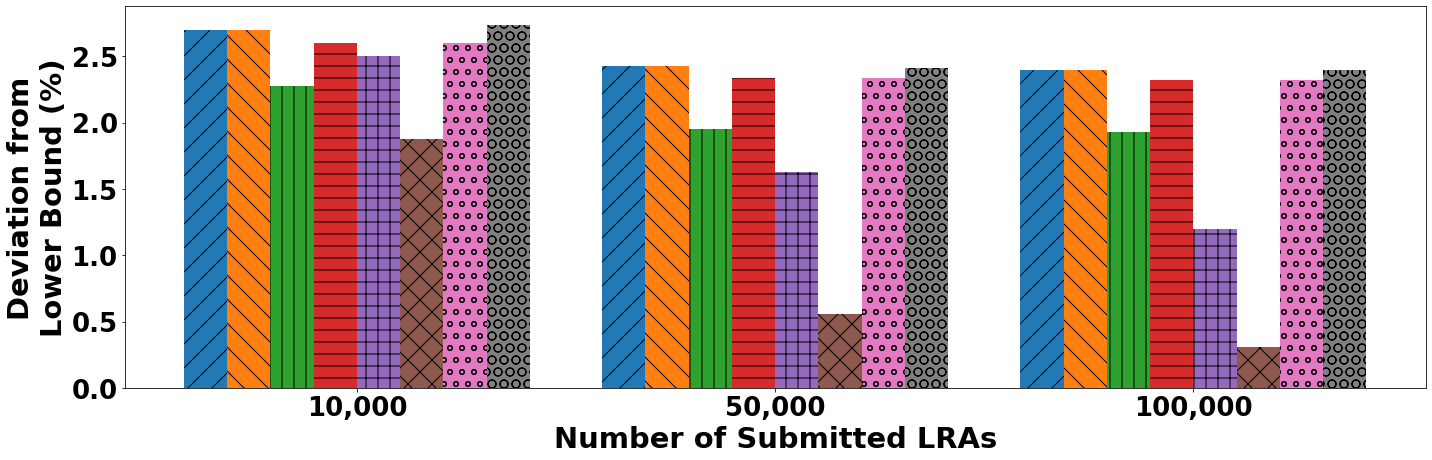

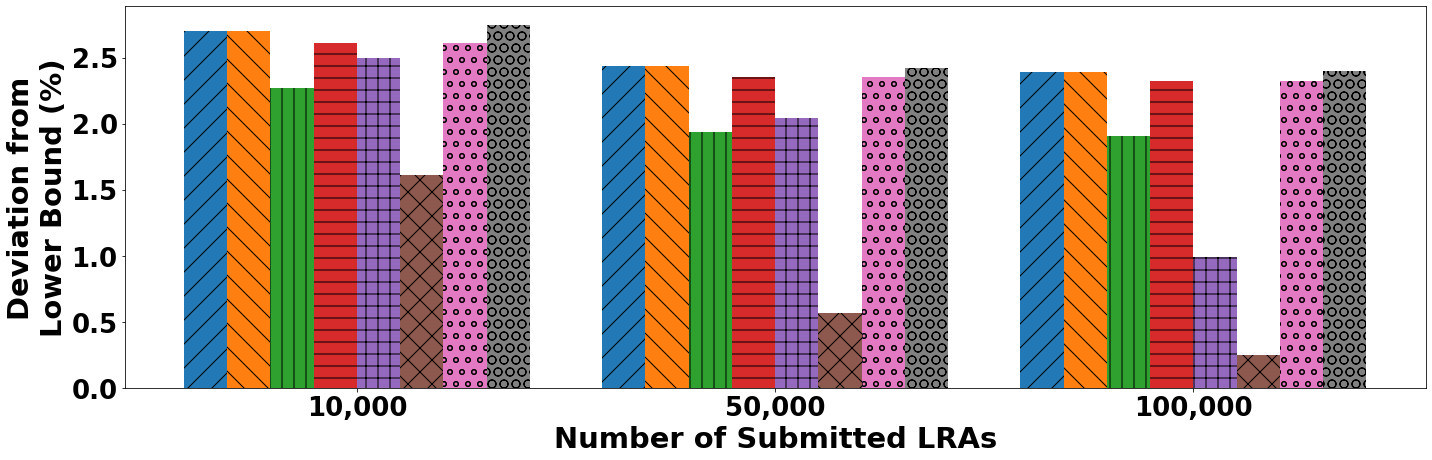

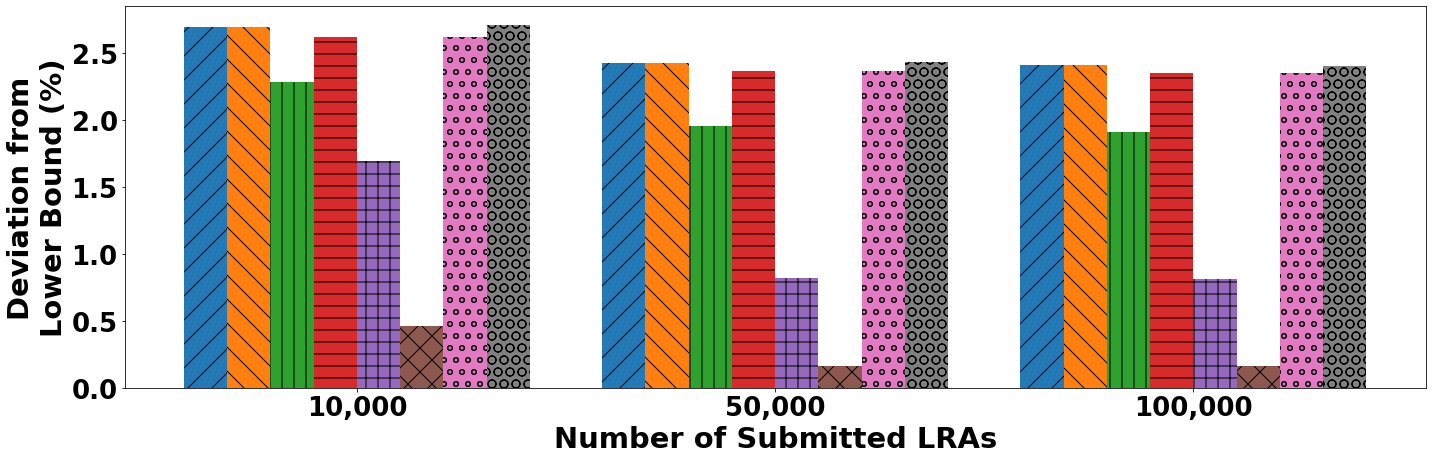

In [45]:
for c in classes: 
    #c = "arbitrary"
    legend_args={'width':20, 'height':6.5, 'loc':'upper right', 'anchor_x':0.95, 'anchor_y':1.0, 'ncol':2, 'fontsize':FONT_SIZE+3, 'enabled':False}
    #legend_args={'loc':'upper right', 'anchor_x':0.95, 'anchor_y':1.0, 'ncol':3, 'fontsize':FONT_SIZE+2, 'enabled':True}
    fig = plot_barchart(twodim_eps_scale, c, df_2d_large_column_names, "Number of Submitted LRAs",
                        'Deviation from\nLower Bound (%)', legend_args)    
    filename = f"{proj_path}/plots/large2D_result_{c}.pdf" 
    fig.savefig(filename)

In [46]:
twodim_time_scale

,class,density,FF,BFD-Avg,WFD-AvgExpo,NCD-DotProduct,RefineWFD-Avg-2,SpreadWFD-Avg,NCD-Fitness,FFD-Degree
0,arbitrary,10000,2.0,2.3,19.0,12.5,24.9,86.3,10.9,2.0
1,arbitrary,50000,66.6,98.4,856.0,646.2,1202.4,5257.7,509.3,66.6
2,arbitrary,100000,297.7,457.6,4659.1,2703.2,6494.4,24230.9,2086.6,295.6
3,normal,10000,2.0,2.8,20.4,13.5,27.7,100.8,11.7,2.0
4,normal,50000,61.5,85.8,762.7,484.9,1316.0,6007.0,355.5,61.0
5,normal,100000,283.3,429.1,4444.2,2796.3,7124.8,26052.2,2151.3,275.8
6,threshold,10000,1.9,2.1,18.7,11.1,39.5,130.8,10.4,2.0
7,threshold,50000,51.5,72.8,593.7,336.6,1495.8,5269.7,301.9,56.9
8,threshold,100000,227.7,327.5,3355.9,1769.1,6429.7,25642.5,1595.2,262.1


In [47]:
twodim_time_scale[twodim_time_scale['class'] == 'arbitrary']

,class,density,FF,BFD-Avg,WFD-AvgExpo,NCD-DotProduct,RefineWFD-Avg-2,SpreadWFD-Avg,NCD-Fitness,FFD-Degree
0,arbitrary,10000,2.0,2.3,19.0,12.5,24.9,86.3,10.9,2.0
1,arbitrary,50000,66.6,98.4,856.0,646.2,1202.4,5257.7,509.3,66.6
2,arbitrary,100000,297.7,457.6,4659.1,2703.2,6494.4,24230.9,2086.6,295.6


In [48]:
twodim_time_scale[twodim_time_scale['class'] == 'arbitrary'][df_2d_large_column_names]/60

,FF,BFD-Avg,WFD-AvgExpo,NCD-DotProduct,RefineWFD-Avg-2,SpreadWFD-Avg,NCD-Fitness,FFD-Degree
0,0.033333,0.038333,0.316667,0.208333,0.415,1.438333,0.181667,0.033333
1,1.110000,1.640000,14.266667,10.770000,20.040,87.628333,8.488333,1.110000
2,4.961667,7.626667,77.651667,45.053333,108.240,403.848333,34.776667,4.926667


In [49]:
twodim_time_scale.groupby("density").mean()/60

,FF,BFD-Avg,WFD-AvgExpo,NCD-DotProduct,RefineWFD-Avg-2,SpreadWFD-Avg,NCD-Fitness,FFD-Degree
density,,,,,,,,
10000,0.032778,0.040000,0.322778,0.206111,0.511667,1.766111,0.183333,0.033333
50000,0.997778,1.427778,12.291111,8.153889,22.301111,91.857778,6.481667,1.025000
100000,4.492778,6.745556,69.217778,40.381111,111.382778,421.808889,32.406111,4.630556


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


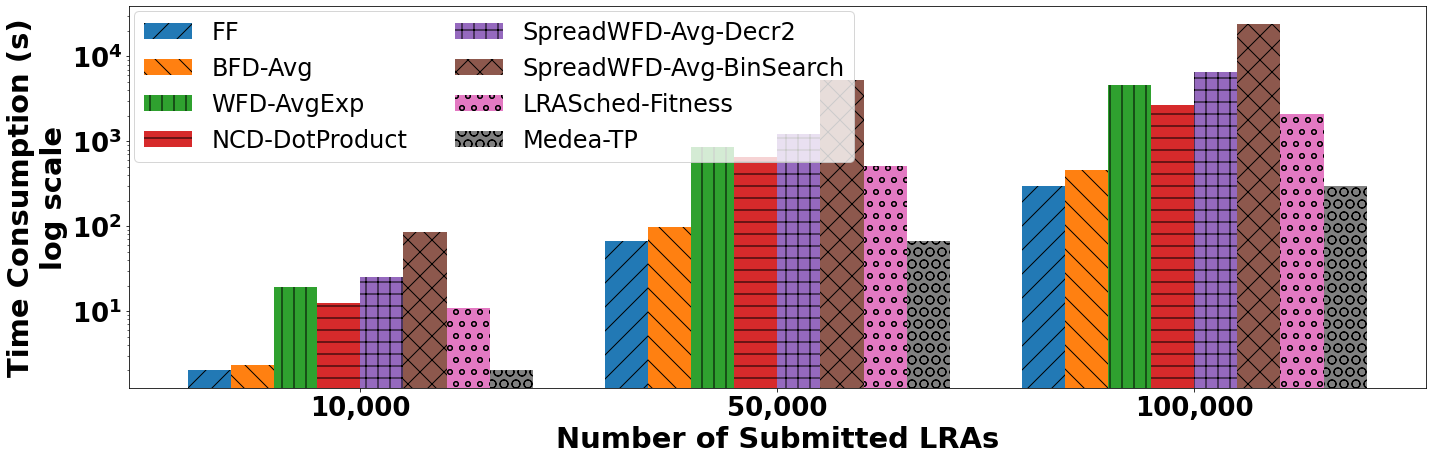

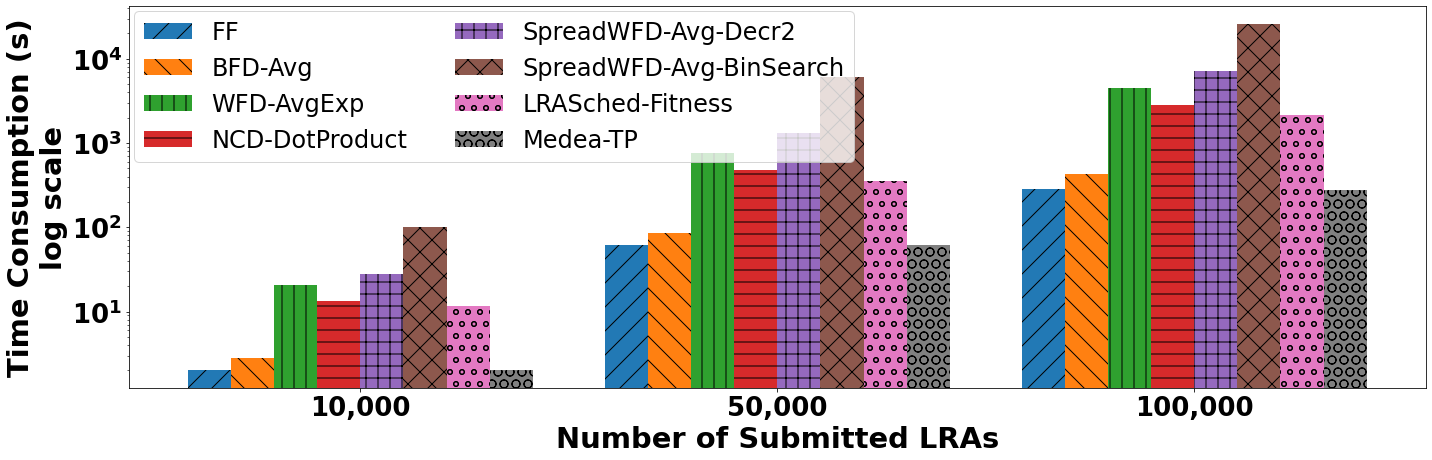

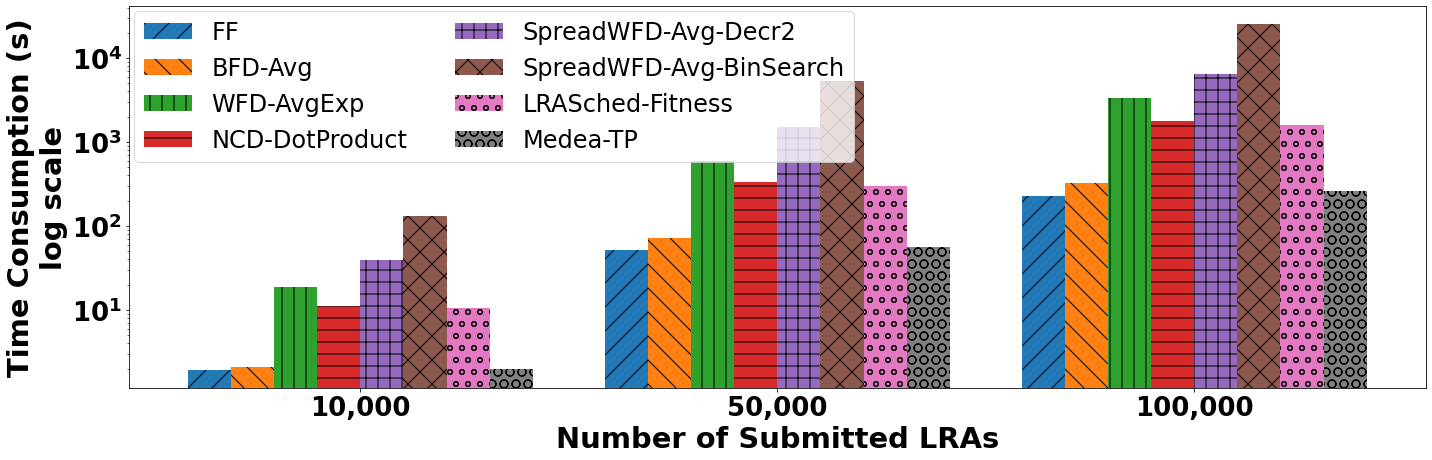

In [50]:
for c in classes: 
#c = "arbitrary"
    #legend_args={'width':14, 'height':6.5, 'loc':'upper right', 'anchor_x':0.95, 'anchor_y':1.0, 'ncol':2, 'fontsize':FONT_SIZE, 'enabled':True}
    legend_args={'width':20, 'height':6.5, 'loc':'upper left', 'anchor_x':-0.005, 'anchor_y':1.02, 'ncol':2, 'fontsize':FONT_SIZE+3, 'enabled':True}
    fig = plot_barchart(twodim_time_scale, c, df_2d_large_column_names, "Number of Submitted LRAs",
                        'Time Consumption (s)\nlog scale', legend_args, True)
    filename = f"{proj_path}/plots/large2D_time_{c}.pdf" 
    fig.savefig(filename)

# Result-2: Time-Varying Res Request

In [51]:
df_ts = pd.read_csv(file_ts, sep='\t')
ts_eps, ts_time = get_exp_results(df_ts, df_ts_column_names)
ts_eps.columns = ['class', 'density'] + df_ts_column_names
ts_time.columns = ['class', 'density'] + df_ts_column_names

## 2.1 Impact of Affinity Density On Effectiveness and Time Consumption

In [52]:
ts_eps.sort_values(by='density')

,class,density,FF,BFD-Avg,WFD-AvgExpo,RefineWFD-Avg-2,SpreadWFD-Avg,FFD-Degree
0,arbitrary,1,10.42,9.18,8.66,2.34,2.43,10.05
3,normal,1,10.43,9.20,8.69,2.37,2.10,10.12
6,threshold,1,10.41,9.28,8.74,2.53,2.21,10.23
1,arbitrary,5,10.25,9.21,8.82,2.98,2.63,9.93
4,normal,5,10.27,9.24,8.82,2.99,2.62,9.89
7,threshold,5,10.26,9.64,9.12,7.23,7.06,10.06
2,arbitrary,10,10.04,9.44,9.17,4.20,3.03,9.91
5,normal,10,10.08,9.49,9.27,4.85,3.87,9.78
8,threshold,10,10.13,10.06,9.70,10.13,10.13,9.92


In [53]:
ts_eps[ts_eps['class'] == 'arbitrary'][df_ts_column_names]

,FF,BFD-Avg,WFD-AvgExpo,RefineWFD-Avg-2,SpreadWFD-Avg,FFD-Degree
0,10.42,9.18,8.66,2.34,2.43,10.05
1,10.25,9.21,8.82,2.98,2.63,9.93
2,10.04,9.44,9.17,4.20,3.03,9.91


In [73]:
ts_eps[ts_eps['class'] == 'arbitrary'][df_ts_column_names].mean()

FF                 10.236667
BFD-Avg             9.276667
WFD-AvgExpo         8.883333
RefineWFD-Avg-2     3.173333
SpreadWFD-Avg       2.696667
FFD-Degree          9.963333
dtype: float64

In [74]:
ts_time[ts_time['class'] == 'arbitrary'][df_ts_column_names].mean()

FF                  23.533333
BFD-Avg             29.133333
WFD-AvgExpo        237.300000
RefineWFD-Avg-2    346.633333
SpreadWFD-Avg      639.100000
FFD-Degree          23.133333
dtype: float64

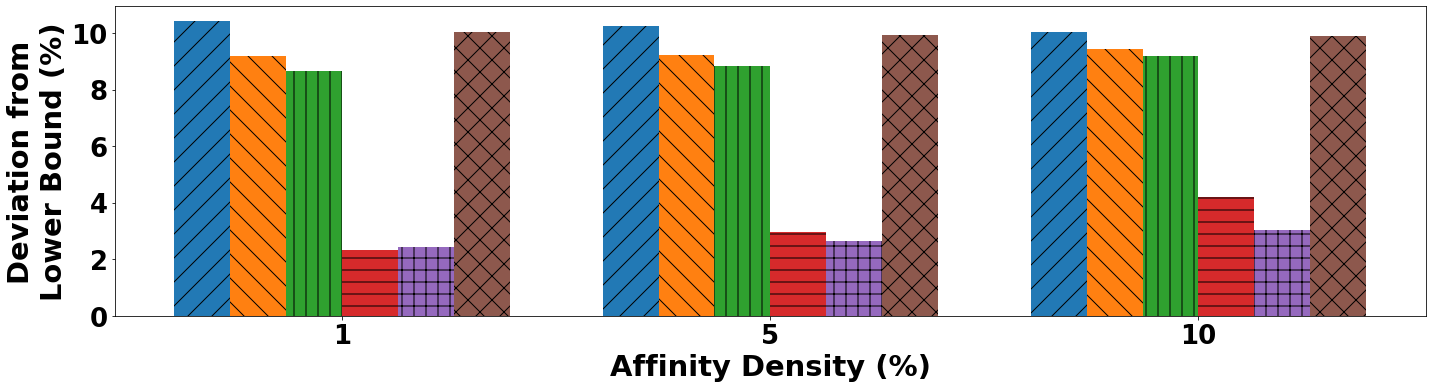

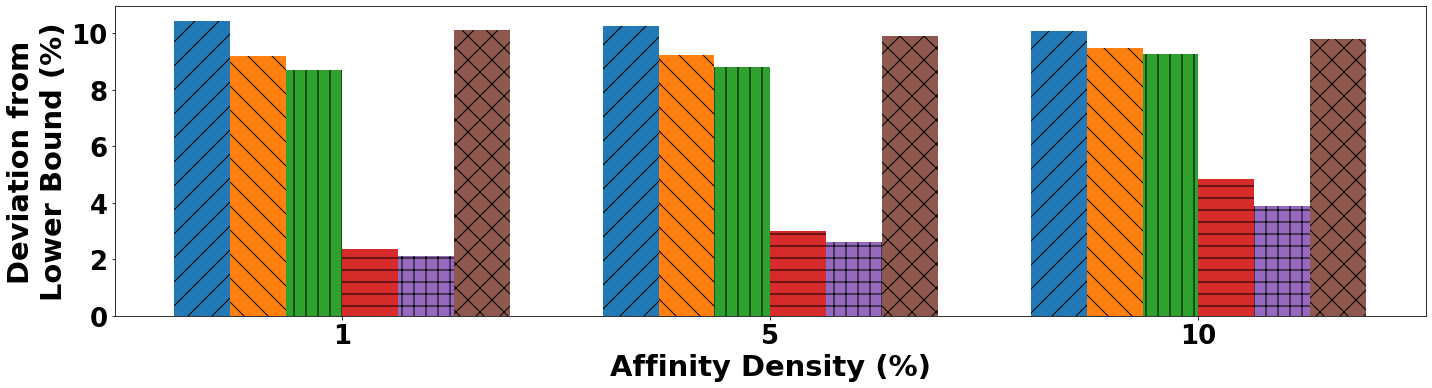

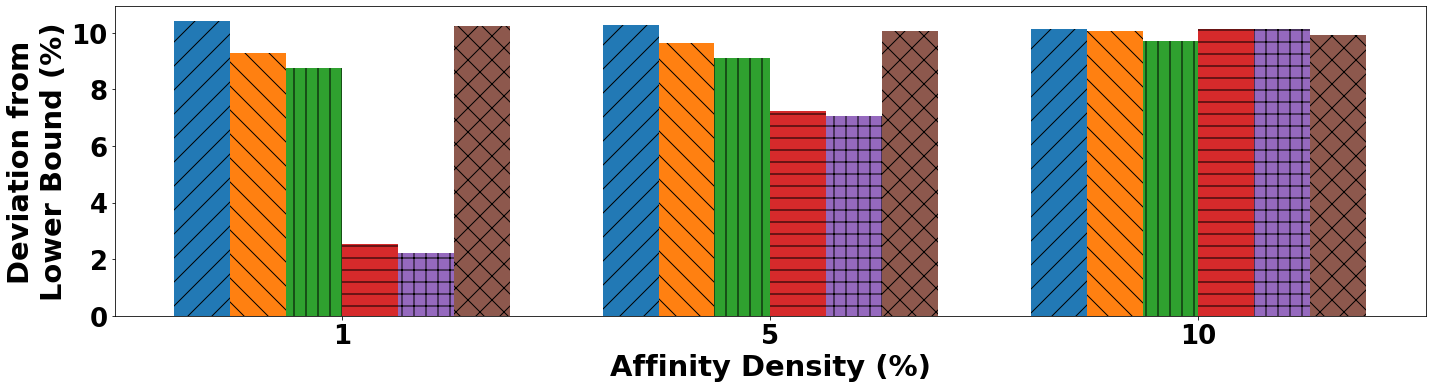

In [54]:
for c in classes: 
#c = "arbitrary"
    #legend_args={'width':14, 'height':6.5,'loc':'center', 'anchor_x':1.15, 'anchor_y':0.4, 'ncol':1, 'fontsize':FONT_SIZE-4, 'enabled':True}
    legend_args={'width':20, 'height':5.5,'loc':'upper left', 'anchor_x':-0.001, 'anchor_y':1.02, 'ncol':3, 'fontsize':FONT_SIZE+2, 'enabled':False}
    fig = plot_barchart(ts_eps, c, df_ts_column_names, "Affinity Density (%)", 'Deviation from\nLower Bound (%)', legend_args)
    filename = f"{proj_path}/plots/densityTS_result_{c}.pdf" 
    fig.savefig(filename)

In [55]:
ts_time.sort_values(by='class')

,class,density,FF,BFD-Avg,WFD-AvgExpo,RefineWFD-Avg-2,SpreadWFD-Avg,FFD-Degree
0,arbitrary,1,9.0,14.0,213.6,136.0,224.9,8.3
1,arbitrary,5,23.3,28.8,246.0,369.4,634.3,23.0
2,arbitrary,10,38.3,44.6,252.3,534.5,1058.1,38.1
3,normal,1,9.6,14.3,215.2,145.7,238.5,8.9
4,normal,5,20.5,25.2,217.2,334.8,580.5,20.1
5,normal,10,35.9,40.9,231.1,467.6,995.0,35.2
6,threshold,1,9.1,13.4,194.9,128.9,218.1,9.7
7,threshold,5,19.1,23.0,194.2,173.0,457.5,34.4
8,threshold,10,31.1,35.2,200.4,59.5,59.5,81.3


In [56]:
ts_time.groupby('density').mean()

,FF,BFD-Avg,WFD-AvgExpo,RefineWFD-Avg-2,SpreadWFD-Avg,FFD-Degree
density,,,,,,
1,9.233333,13.900000,207.900000,136.866667,227.166667,8.966667
5,20.966667,25.666667,219.133333,292.400000,557.433333,25.833333
10,35.100000,40.233333,227.933333,353.866667,704.200000,51.533333


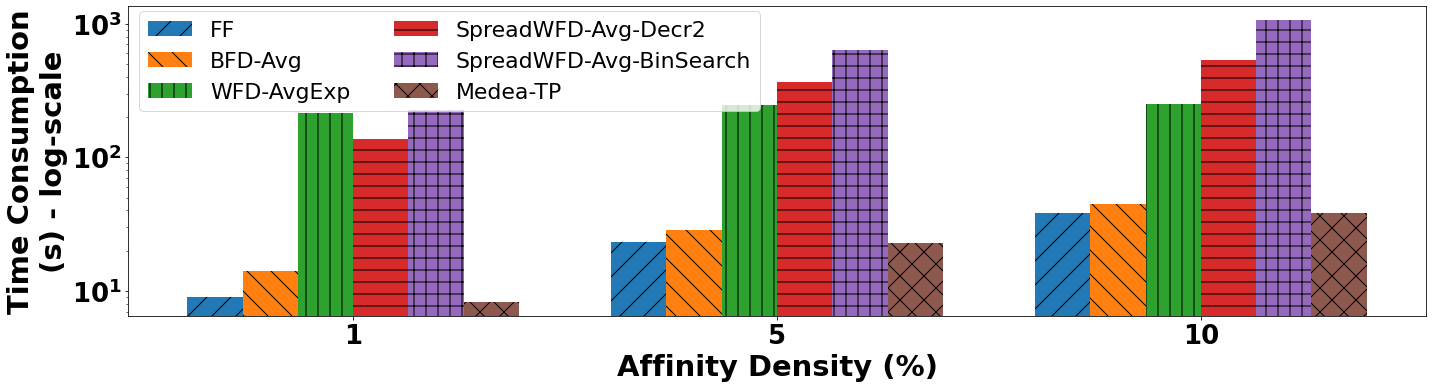

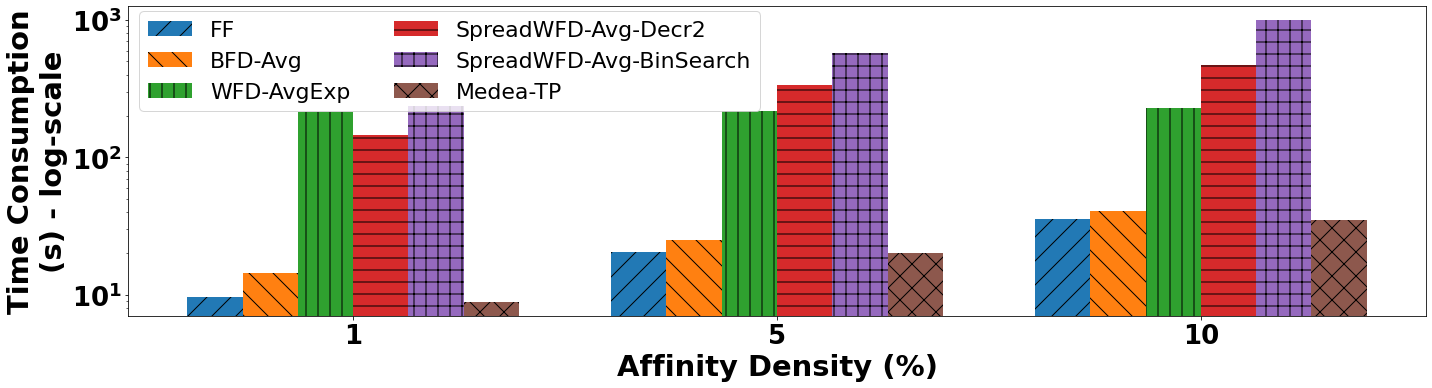

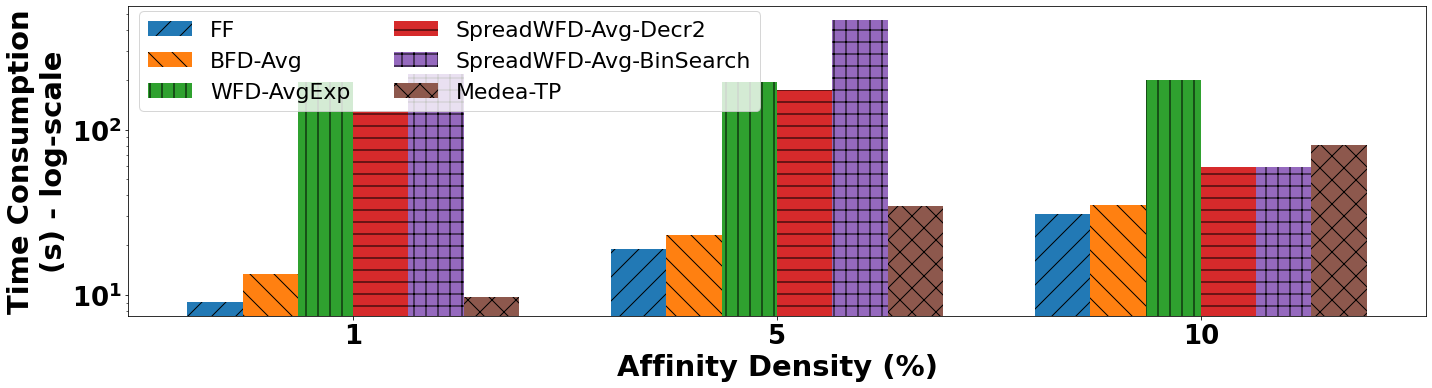

In [58]:
for c in classes: 
#c = "arbitrary"
    legend_args={'width':20, 'height':5.5,'loc':'upper left', 'anchor_x':0.0, 'anchor_y':1.02, 'ncol':2, 'fontsize':FONT_SIZE+1, 'enabled':True}

    fig = plot_barchart(ts_time, c, df_ts_column_names, "Affinity Density (%)", 'Time Consumption\n(s) - log-scale', legend_args, True)

    filename = f"{proj_path}/plots/densityTS_time_{c}.pdf" 
    fig.savefig(filename)

## 2.2 Impact of LRA Submission Scale On Effectiveness and Time Consumption

In [59]:
df_large_ts = pd.read_csv(file_largeTS, sep='\t') ## df_TS_large

ts_eps_scale, ts_time_scale = get_scale_exp_results(df_large_ts, df_ts_large_column_names)
ts_eps_scale.columns = ['class', 'density'] + df_ts_large_column_names
ts_time_scale.columns = ['class', 'density'] + df_ts_large_column_names

In [60]:
ts_eps_scale#[ts_eps_scale['class'] == 'arbitrary'].sort_values(by='density')

,class,density,FF,BFD-Avg,WFD-AvgExpo,RefineWFD-Avg-2,SpreadWFD-Avg,FFD-Degree
0,arbitrary,10000,5.35,4.86,4.66,4.33,3.16,5.34
1,arbitrary,50000,5.93,5.66,5.59,4.13,3.69,5.96
2,arbitrary,100000,6.11,5.93,5.82,4.31,3.76,6.10
3,normal,10000,5.35,4.87,4.71,4.34,3.22,5.32
4,normal,50000,5.93,5.68,5.61,4.13,3.70,5.95
5,normal,100000,6.11,5.92,5.82,4.31,3.76,6.03
6,threshold,10000,5.34,4.85,4.68,4.54,3.25,5.39
7,threshold,50000,5.93,5.68,5.61,4.13,3.71,5.94
8,threshold,100000,6.13,5.93,5.82,4.32,3.76,6.09


In [61]:
ts_eps_scale[ts_eps_scale['class'] == 'arbitrary']

,class,density,FF,BFD-Avg,WFD-AvgExpo,RefineWFD-Avg-2,SpreadWFD-Avg,FFD-Degree
0,arbitrary,10000,5.35,4.86,4.66,4.33,3.16,5.34
1,arbitrary,50000,5.93,5.66,5.59,4.13,3.69,5.96
2,arbitrary,100000,6.11,5.93,5.82,4.31,3.76,6.10


In [62]:
ts_eps_scale[df_ts_large_column_names].mean()

FF                 5.797778
BFD-Avg            5.486667
WFD-AvgExpo        5.368889
RefineWFD-Avg-2    4.282222
SpreadWFD-Avg      3.556667
FFD-Degree         5.791111
dtype: float64

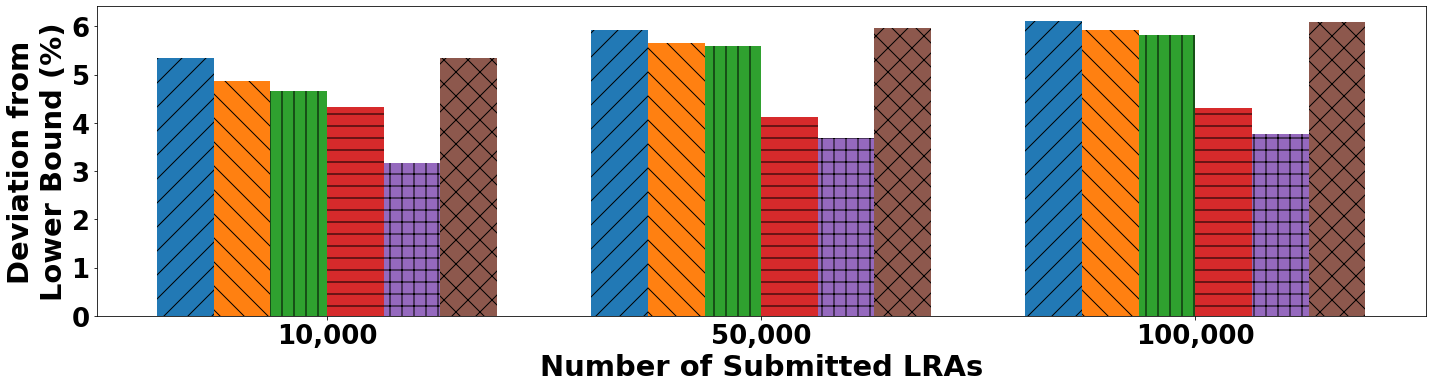

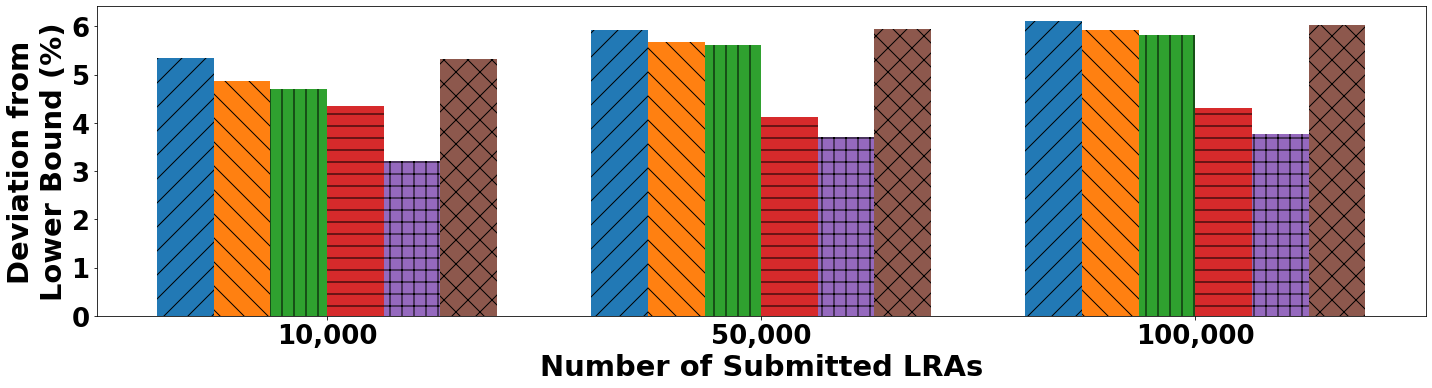

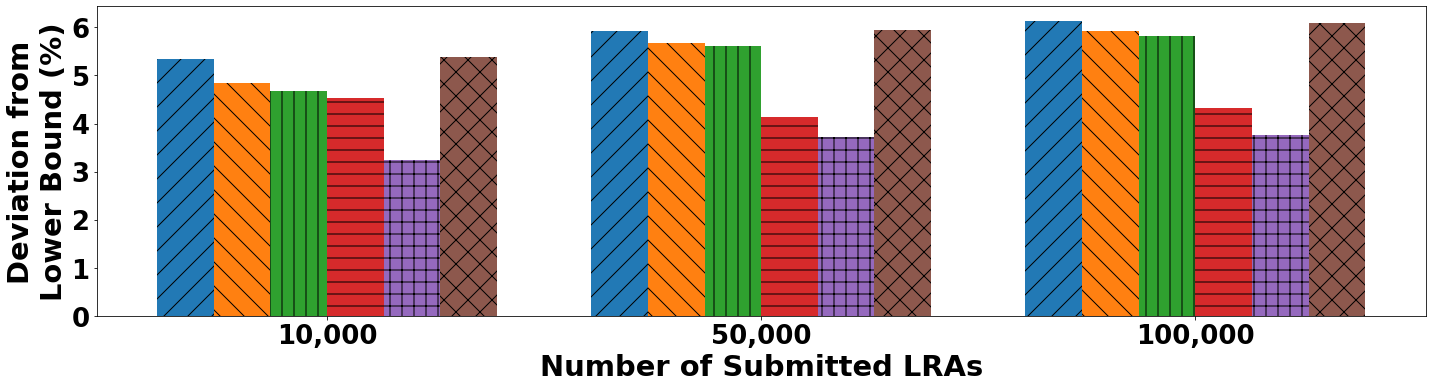

In [63]:
for c in classes: 
#c = "arbitrary"
    legend_args={'width':20, 'height':5.5,'loc':'upper left', 'anchor_x':0.0, 'anchor_y':1.02, 'ncol':3, 'fontsize':FONT_SIZE+2, 'enabled':False}
    fig = plot_barchart(ts_eps_scale, c, df_ts_large_column_names, "Number of Submitted LRAs",
                        'Deviation from\nLower Bound (%)', legend_args)    
    filename = f"{proj_path}/plots/largeTS_result_{c}.pdf" 
    fig.savefig(filename)

In [64]:
ts_time_scale

,class,density,FF,BFD-Avg,WFD-AvgExpo,RefineWFD-Avg-2,SpreadWFD-Avg,FFD-Degree
0,arbitrary,10000,5.3,6.1,155.5,36.7,157.8,5.0
1,arbitrary,50000,260.3,326.9,5392.5,1905.1,6888.3,259.7
2,arbitrary,100000,832.0,1090.7,17492.6,9088.8,38942.6,829.2
3,normal,10000,5.4,6.4,169.8,37.4,157.5,5.3
4,normal,50000,150.5,194.0,3403.4,2117.6,6604.6,151.3
5,normal,100000,803.0,1067.1,18373.9,10562.7,43437.5,790.0
6,threshold,10000,5.3,5.7,162.9,31.5,136.6,5.2
7,threshold,50000,135.3,165.7,3425.9,1464.8,5781.3,136.4
8,threshold,100000,609.6,765.9,14807.8,7010.7,36895.8,641.6


In [65]:
ts_time_scale[ts_time_scale['class'] == 'arbitrary'][df_ts_large_column_names]/60

,FF,BFD-Avg,WFD-AvgExpo,RefineWFD-Avg-2,SpreadWFD-Avg,FFD-Degree
0,0.088333,0.101667,2.591667,0.611667,2.630000,0.083333
1,4.338333,5.448333,89.875000,31.751667,114.805000,4.328333
2,13.866667,18.178333,291.543333,151.480000,649.043333,13.820000


In [66]:
ts_time_scale.groupby('density').mean()

,FF,BFD-Avg,WFD-AvgExpo,RefineWFD-Avg-2,SpreadWFD-Avg,FFD-Degree
density,,,,,,
10000,5.333333,6.066667,162.733333,35.200000,150.633333,5.166667
50000,182.033333,228.866667,4073.933333,1829.166667,6424.733333,182.466667
100000,748.200000,974.566667,16891.433333,8887.400000,39758.633333,753.600000


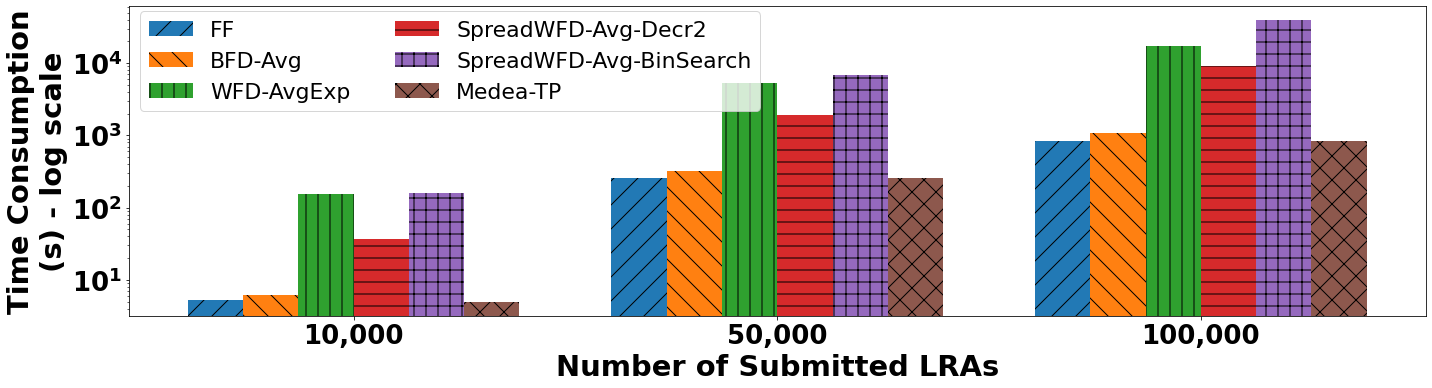

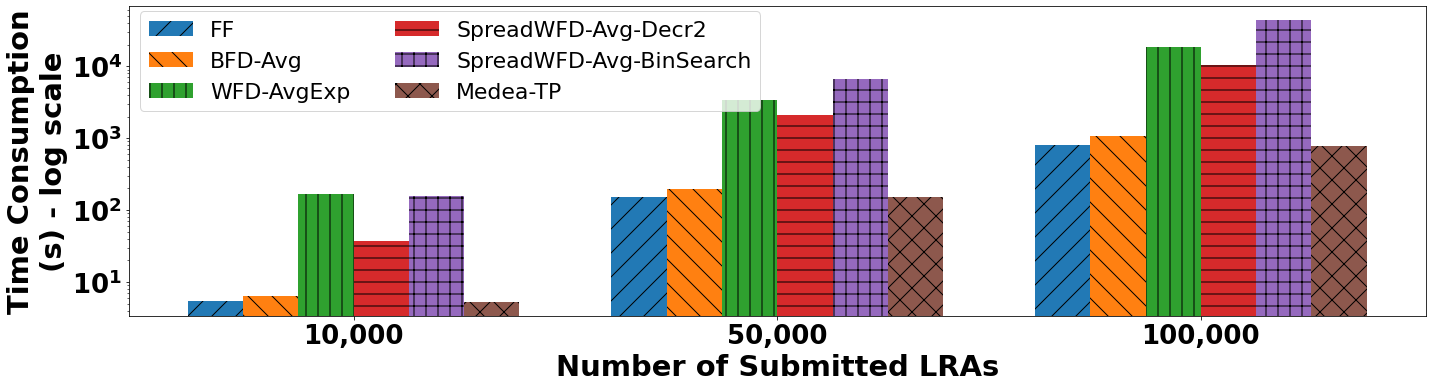

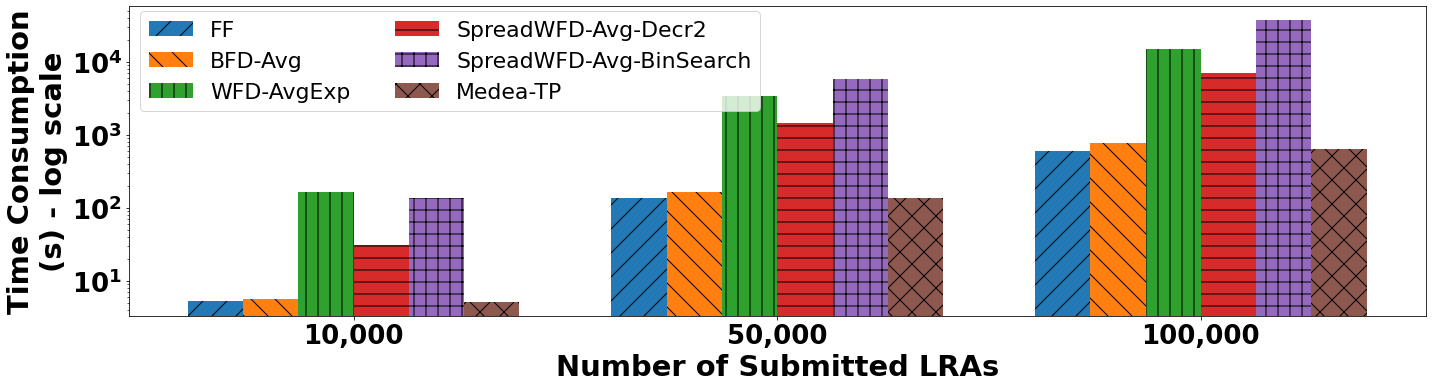

In [67]:
for c in classes: 
#c = "arbitrary"    
    legend_args={'width':20, 'height':5.5,'loc':'upper left', 'anchor_x':0.0, 'anchor_y':1.02, 'ncol':2, 'fontsize':FONT_SIZE+1, 'enabled':True}
    fig = plot_barchart(ts_time_scale, c, df_ts_large_column_names, "Number of Submitted LRAs",
                        'Time Consumption\n(s) - log scale', legend_args, True)

    filename = f"{proj_path}/plots/largeTS_time_{c}.pdf" 
    fig.savefig(filename)